# **CIS 5450 Final Project - Writing Quality Prediction**

**Team Members: Gaoxiang Luo, Alan Zhu, Hatoon Gul**

## Part 1: Introduction

This project aims to **predict the overall quality of writing based on typing behavior**, using a dataset of keystroke logs that capture features of the writing process. Traditional writing assessments primarily focus on the final written product. This dataset emphasizes the process of writing, investigating how various writing behaviors, like pausing patterns, additions or deletions, and revisions, impact the quality of writing. More importantly, the scale of this dataset allows us to use data-driven approaches to investigate the relationship between writing behaviors and writing quality, which could lead to more robust and generalizable findings.

The insights gained from this project could inform the development of intelligent tutoring systems and more effective writing instruction methodologies. It could help in designing tools that focus on the writing process, aiding learners in improving their writing skills. Furthermore, by focusing on process features from keystroke log data, this project could help shift the attention of learners to their text production process. This shift could enhance their autonomy, metacognitive awareness, and self-regulation in writing.

We're espectially thankful for the Learning Agency Lab at Vanderbilt University for open-soucing the dataset on Kaggle.

## Part 2: Data Loading & Exploratory Data Analysis

Download and install dependencies

In [45]:
!pip install catboost
!pip install langchain
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=75ecb7342b467e9681caf75b64fda8e4a553616c12f34bdd5cd4196128bde748
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [46]:
import os
import re
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import pandasql as ps
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from collections import defaultdict, Counter
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import SystemMessage
from langchain.prompts.chat import HumanMessagePromptTemplate, ChatPromptTemplate

random.seed(42)
random_seed = 42
plt.style.use("ggplot")
sns.set_palette("rocket")
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
pd.set_option("display.max_columns", None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
palette = sns.color_palette("rocket")

### 2.1 Data Loading

In [ ]:
# If you're running it Colab
from google.colab import drive
drive.mount('/content/drive')
INPUT_DIR = '/content/drive/MyDrive/Linking Writing Processes to Writing Quality/Colab/linking-writing-processes-to-writing-quality'

Mounted at /content/drive


In [ ]:
INPUT_DIR = 'drive/MyDrive/Optiver - Trading at the close/Colab/linking-writing-processes-to-writing-quality/'

In [ ]:
# If you're running it locally
INPUT_DIR = 'linking-writing-processes-to-writing-quality'

In [ ]:
train_logs = pd.read_csv(f'{INPUT_DIR}/train_logs.csv')
train_scores = pd.read_csv(f'{INPUT_DIR}/train_scores.csv')

In [ ]:
# Preview of the data
print(f"Size of the Dataset: {train_logs.shape}")
train_logs

Size of the Dataset: (8405898, 11)


id  event_id  down_time  up_time  action_time       activity  \
0        001519c8         1       4526     4557           31  Nonproduction   
1        001519c8         2       4558     4962          404  Nonproduction   
2        001519c8         3     106571   106571            0  Nonproduction   
3        001519c8         4     106686   106777           91          Input   
4        001519c8         5     107196   107323          127          Input   
...           ...       ...        ...      ...          ...            ...   
8405893  fff05981      3615    2063944  2064440          496  Nonproduction   
8405894  fff05981      3616    2064497  2064497            0  Nonproduction   
8405895  fff05981      3617    2064657  2064765          108        Replace   
8405896  fff05981      3618    2069186  2069259           73  Nonproduction   
8405897  fff05981      3619    2070065  2070133           68          Input   

        down_event   up_event text_change  cursor_position  word_count  
0        Leftclick  Leftclick    NoChange                0           0  
1        Leftclick  Leftclick    NoChange                0           0  
2            Shift      Shift    NoChange                0           0  
3                q          q           q                1           1  
4                q          q           q                2           1  
...            ...        ...         ...              ...         ...  
8405893  Leftclick  Leftclick    NoChange             1031         240  
8405894      Shift      Shift    NoChange             1031         240  
8405895          q          q      q => q             1031         240  
8405896  Leftclick  Leftclick    NoChange             1028         240  
8405897          .          .           .             1029         240  

[8405898 rows x 11 columns]

**Data Collection Procedure**

The project hired its participants from Amazon Mechanical Turk, a crowdsourcing platform. The participants were invited to log into a website that had demographic survey, typing tests, an argumentative writing exercise, and a vocabulary assessment. They were instructed to use only computers that had a keyboard.

During the arugmentative writing task, participants were asked to write an argumentative essay within 30 minutes with a Scholastic Assessment Test (SAT) prompt. To control for potential prompt effects, four SAT based writing prompts were used and each participant was randomly assigned one prompt. The task also included instructions on important tenants of an argumentative essay along with a set of rules for the writing task.

The task required participants to write an essay of at least 200 words in 3 paragraphs without online or offline references. To ensure that the participants stayed focused on the task during writing, and to track their behavior, the task page issued warnings whenever the participant was inactive for more than 2 minutes or moved to a new window in the process of writing. Below is a screenshot of the writing page:

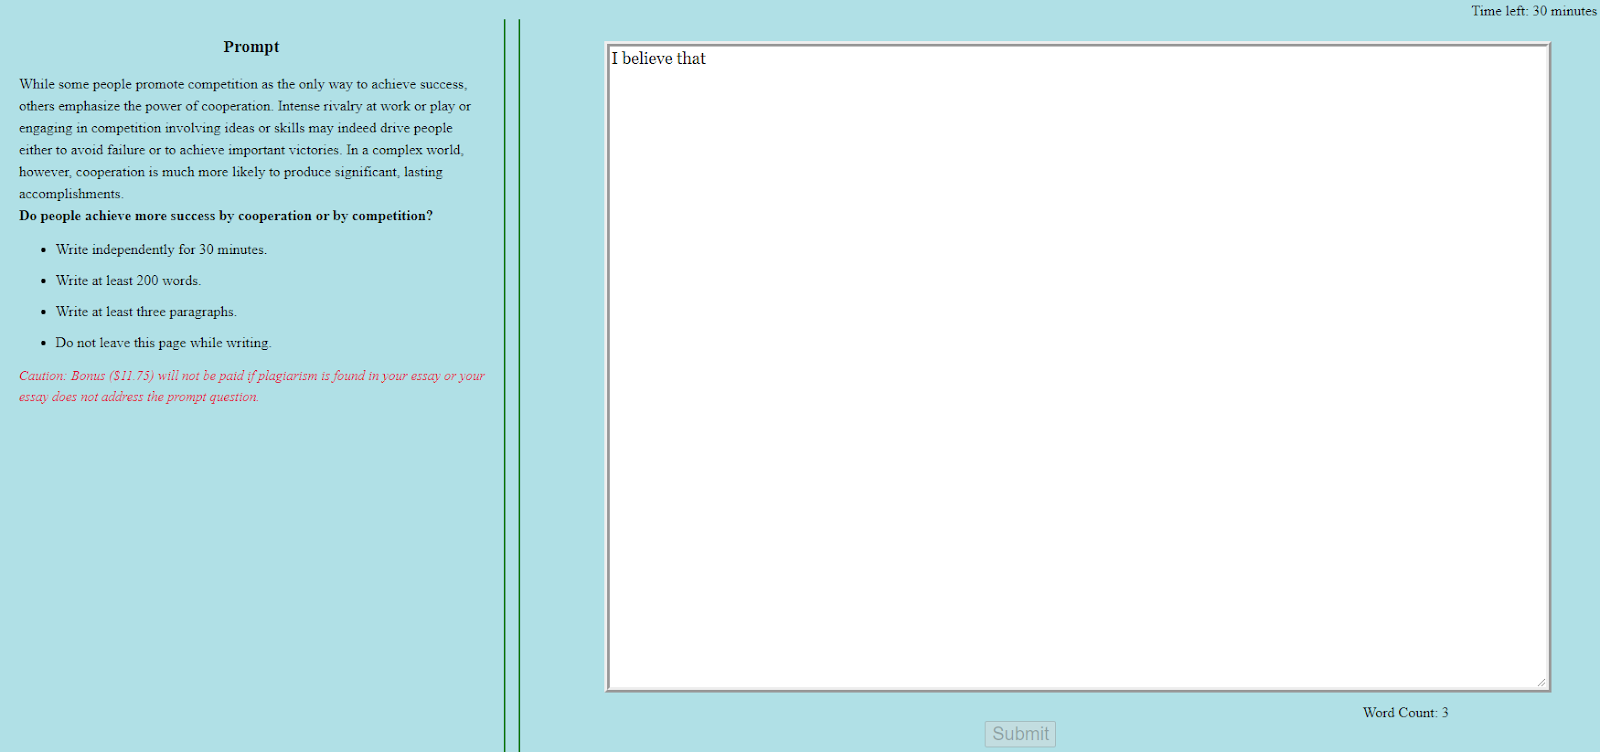

**Keystroke Logging Program**

A keystroke logging program was written in vanilla JavaScript to collect participants' keystroke information. The program listened to the keystroke and mouse events in the designated text input area using JavaScript's addEvent Listener method. It also collected time stamp and cursor position information for each keystroke or mouse operation. The following data was collected:

* id - The unique ID of the essay
*event_id - The index of the event, ordered chronologically
*down_time - The time of the down event in milliseconds
*up_time - The time of the up event in milliseconds
*action_time - The duration of the event (the difference between down_time and up_time)
*activity - The category of activity which the event belongs to
*Nonproduction - The event does not alter the text in any way
*Input - The event adds text to the essay
*Remove/Cut - The event removes text from the essay
*Paste - The event changes the text through a paste input
*Replace - The event replaces a section of text with another string
*Move From [x1, y1] To [x2, y2] - The event moves a section of text spanning *character index x1, y1 to a new location x2, y2
*down_event - The name of the event when the key/mouse is pressed
*up_event - The name of the event when the key/mouse is released
*text_change - The text that changed as a result of the event (if any)
*cursor_position - The character index of the text cursor after the event
*word_count - The word count of the essay after the event

### 2.2 Exploratory Data Analysis

#### 2.2.1 Target Variable

To begin, we would like to know the distribution of our target variable, which is the overall quality of writing, because it will help me decide if our target variable is imbalanced or not.

Mean of the Score: 3.71125050586807
Std of the Score: 1.0249374891448726


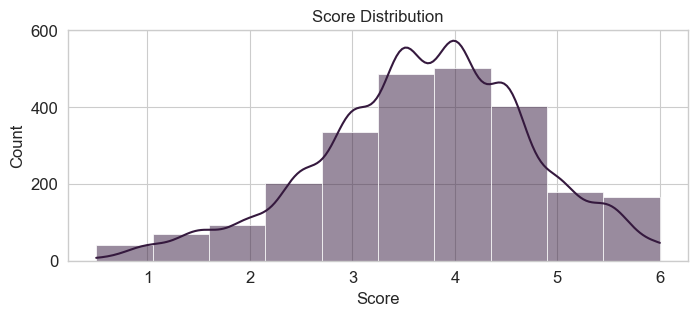

In [ ]:
# mean and std of the score
print(f"Mean of the Score: {train_scores['score'].mean()}")
print(f"Std of the Score: {train_scores['score'].std()}")
plt.figure(figsize=(8, 3))
# plot the histogram with searborn
sns.histplot(train_scores['score'], kde=True, bins=10)
plt.title('Score Distribution', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Take away:
- The above histogram shows that the distribution is slightly left-skewed, with a mean of 3.71 and a standard deviation of 1.02. The distribution is also slightly bimodal, with two peaks at 3 and 4. The distribution makes sense because we're expecting most people to be an average SAT essay writter.
- We're expecting any models to perform well on the average writters, but not so well on the extreme writters (very good or very bad).

#### 2.2.2 Feature Variables

We will look at them by their intricate meaning and their distribution by groups.
- Event: `down_event`, `up_event`
- Time: `down_time`, `up_time`, `action_time`
- Location: `cursor_position`
- Edit: `activity`, `cursor_position`, `word_count`

##### 2.2.2.1 Event

As the dataset is a sequence of events defining the user's writing process, we would like to know the distribution of the number of events and how it relates to the overall quality of writing. Because there are many logs for each essay, we need to aggregate the logs by essay and then plot the distribution.

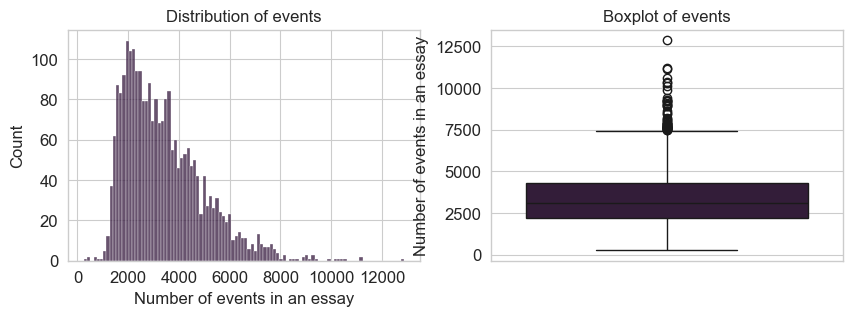

In [ ]:
event_stats = train_logs.groupby("id")['event_id'].count()

fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].set_title('Distribution of events', fontsize=12)
ax[0].set_xlabel('Number of events in an essay', fontsize=12)
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of events', fontsize=12)
ax[1].set_ylabel('Number of events in an essay', fontsize=12)
sns.boxplot(event_stats, ax=ax[1])
plt.show()

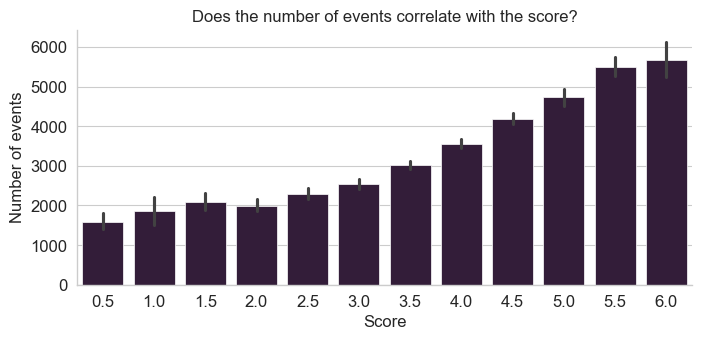

In [ ]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
catplot.fig.set_figwidth(7)
catplot.fig.set_figheight(3)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of events', fontsize=12)
plt.title('Does the number of events correlate with the score?', fontsize=12)
plt.show()

Take away:
- Writers with more input events tend to have higher overall quality of writing. This makes sense because writers with more input events tend to spend more time on polishing, which represents a sophisticated thought process, and thus usually a higher quality of writing.

#### 2.2.2.2 Time

Pauses are important indicators of the writing process. We would like to know the distribution of the pause time and how it relates to the overall quality of writing.

In [ ]:
train_logs_scores_df = train_logs.merge(train_scores, on='id', how='left')
train_logs_agg_df = train_logs_scores_df.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count', 'score']].mean().reset_index()

In [ ]:
def plot_dist_box(data: pd.Series, target: pd.Series) -> None:

    color = random.choice(color_pal)

    # Create a figure with two subplots
    _, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the distribution plot on the first subplot
    sns.histplot(data, ax=axes[0], color=color)
    axes[0].set_title('Distribution Plot', fontsize=12)

    # Plot the box plot on the second subplot
    sns.boxplot(data, ax=axes[1], color=color)
    axes[1].set_title('Box Plot', fontsize=12)

    # Plot the cdf plot on the third subplot
    sns.ecdfplot(data, ax=axes[2], color=color)
    axes[2].set_title('CDF Plot', fontsize=12)

    # Plot the scatter plot on the fourth subplot with the target variable
    sns.scatterplot(x=data, y=target, ax=axes[3], color=color)
    axes[3].set_title('Scatter Plot', fontsize=12)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

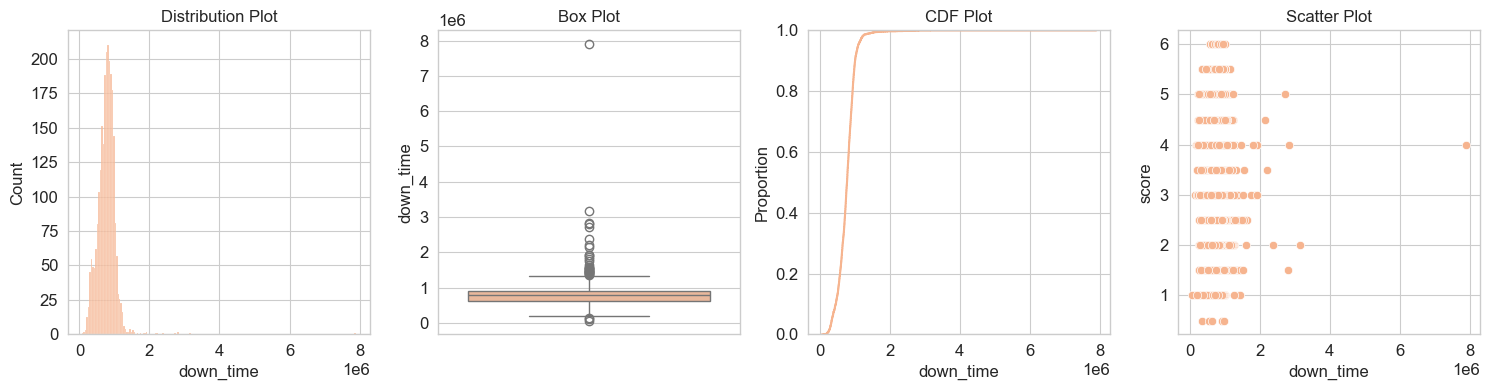

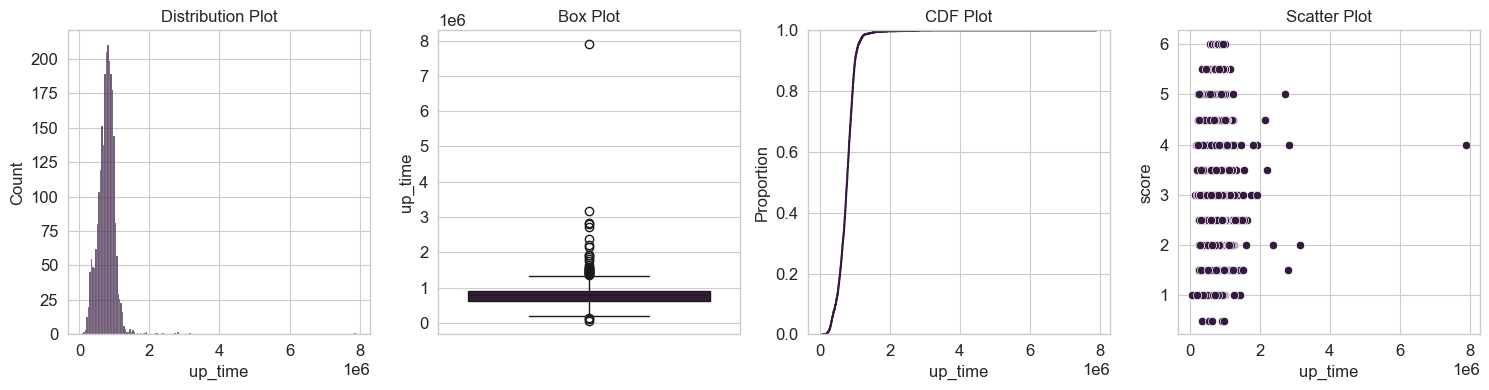

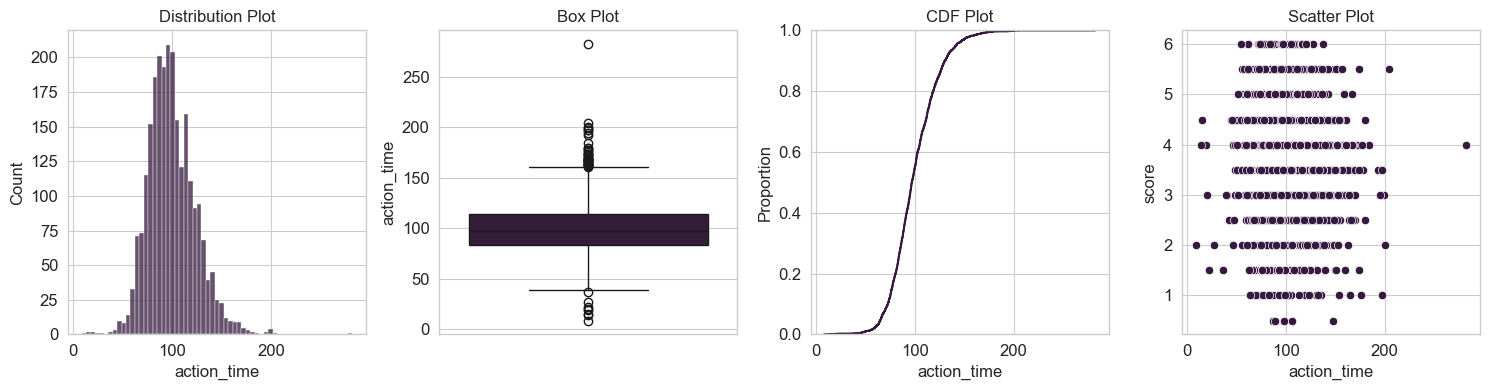

In [ ]:
num_cols = ['down_time', 'up_time', 'action_time']
for col in num_cols:
    plot_dist_box(train_logs_agg_df[col], train_logs_agg_df['score'])

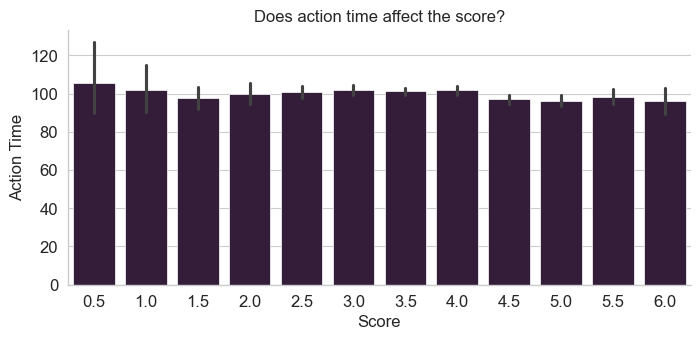

In [ ]:
catplot = sns.catplot(data=train_logs_agg_df, x="score", y="action_time", kind="bar", height=5, aspect=8/5)
catplot.fig.set_figwidth(7)
catplot.fig.set_figheight(3)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Action Time', fontsize=12)
plt.title('Does action time affect the score?', fontsize=12)
plt.show()

Take away:
- We can see that the existance of outliers in time-related features especially `down_time` and `up_time`, which makes the CDF plot imbalance.
- Although the trend is not profound, we can see that good writers tend to have shorter pauses than bad writers.
- We can also see that the average writer has less standard deviation in pause time than the good and bad writers. This makes sense because the average writer is more consistent in their writing process, where the good and bad writers are more likely to have a more diverse writing process.

#### 2.2.2.3 Location

Writer may move their cursor differently based on their wiritng process. The cursor position is defined as the character index of the text cursor after an event. In other words, it is the location where the next text input would go into the essay.

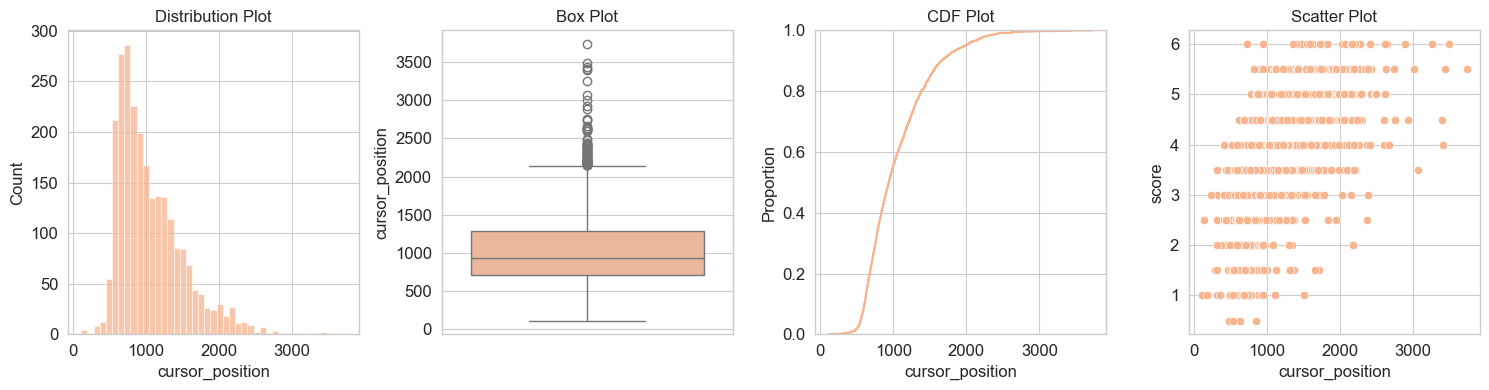

In [ ]:
plot_dist_box(train_logs_agg_df['cursor_position'], train_logs_agg_df['score'])

Take away:
- While the cursor position for most are falling into a somewhat standard range, we see the good writers tend to move their cursor "crasily" (i.e. more extreme cursor positions), which makes sense because they are more likely to revise their writing.

#### 2.2.2.4 Edit

Here we explore the quantitative features related to the actual editing process, including the final word counts, the revising behavisor. For example, a user may delete a word by deleting the whole word or by deleting one character at a time. This may also be related to the overall quality of writing. For another example, whether a user like to always type in new words or copy and paste from the original text may also be related to the overall quality of writing.

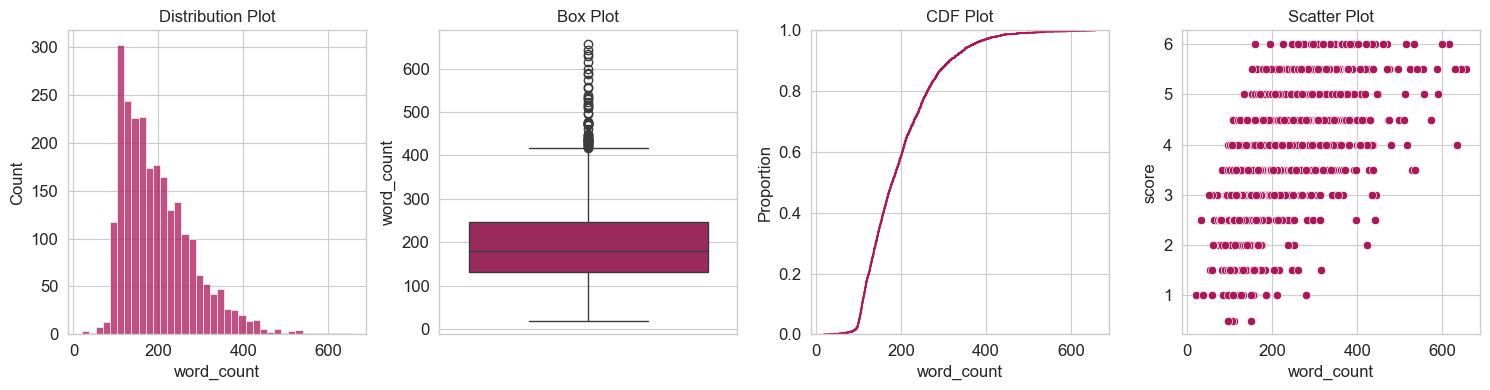

In [ ]:
plot_dist_box(train_logs_agg_df['word_count'], train_logs_agg_df['score'])

In [ ]:
train_logs['activity'].value_counts()[:10]

Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [13, 65] To [9, 61]                   1
Move From [274, 314] To [299, 339]              1
Move From [624, 625] To [845, 846]              1
Move From [1861, 2063] To [1766, 1968]          1
Name: activity, dtype: int64

In [ ]:
train_logs['text_change'].value_counts()[:100]

q                     6128208
                      1376829
NoChange               703851
.                       67797
,                       54797
                       ...   
qqqqqqqqqqqqq => q          8
qqq q                       8
qqq qq => q                 8
qqqqqqqqqqq                 8
qqqq qq                     8
Name: text_change, Length: 100, dtype: int64

Take away:
- Good writers tend to have more word counts than bad writers.
- `activity` and `text_change` are extremely long-tailed, which may not be as useful as features unless we do some feature engineering.

### 2.2.3 Feature Correlation

Here we find the correlation matrix for the raw data. There is a fairly significant amount of correlation, however we don't remove features in this step because we would like to use all information to engineer new features.

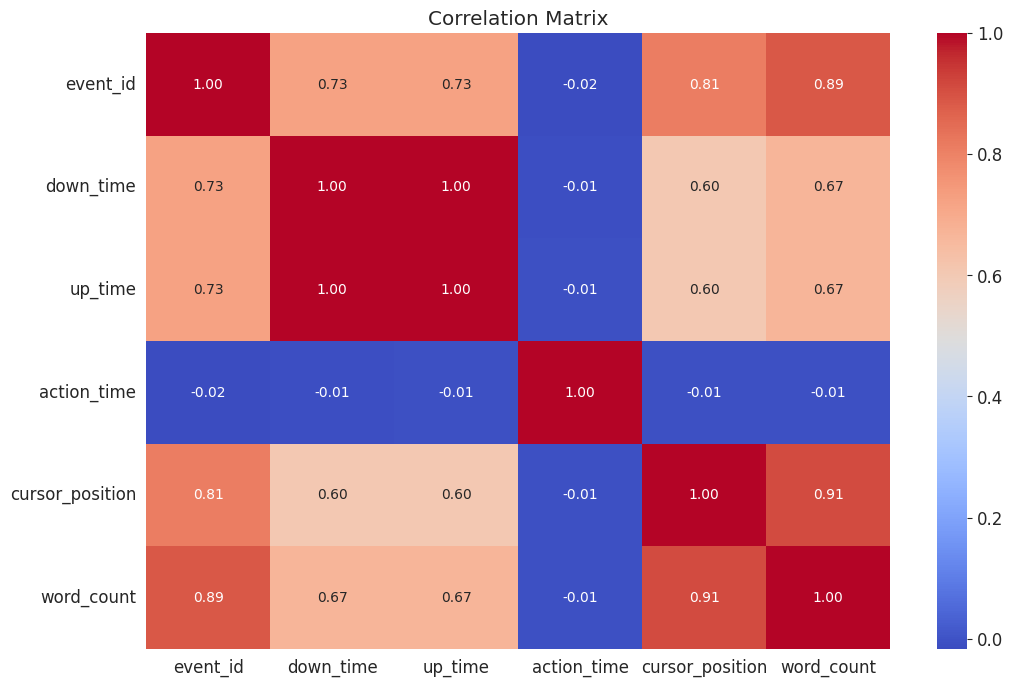

In [ ]:
correlation_matrix = train_logs.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Part 3: Feature Engineering

### 3.1 Statistics Features

There are in total 8,405,898 user logs but there are only 2,471 unique essays that we need to grade. This means that many user logs correspond to the same essay. Therefore, first thing that comes to mind is to aggregate the user logs by essay and then extract statistics features from the aggregated logs. The statistics features include the mean, standard deviation, min, max, quantiles (including median), standard error of the mean, sum, skewness, and kurtosis of our raw features in our EDA.

### 3.2 Frequency Features (Count, TF-IDF)

Writers may have repeatitive patterns in their writing process. For example, a writer may have a habit of deleting a word and then retype it again. This may be related to the overall quality of writing. Therefore, we would like to extract frequency features from the raw features in our EDA. The frequency features include simplying counting. However, in NLP bigger counts may not always impose more importance (e.g., pronouns, stopwords). Furthermore, counts doesn't utilize the order of the words. Therefore, we would also like to extract TF-IDF features from the raw features in our EDA.

The following code encompases the above two feature engineering steps.

In [ ]:
class Preprocessor:

    def __init__(self, seed):
        self.seed = seed

        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste'] # prominent activities
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',',
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified'] # prominent events
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':'] # prominent text changes
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100] # shifting window

        self.idf = defaultdict(float) # TD-IDF

    # Handle counts in activities
    def activity_counts(self, df):
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index() # aggregate by essay and form a list for each activity
        ret = list() # init empty list
        for li in tqdm(tmp_df['activity'].values): # extract activity list for one essay
            items = list(Counter(li).items()) # make it [(activity1:count1), (activity2:count2), ...]
            di = dict() # empty dict
            for k in self.activities: # init to 0
                di[k] = 0
            for item in items:
                k, v = item[0], item[1] # k: activity, v: count
                if k in di:
                    di[k] = v
            ret.append(di) # add to the activity count of this essay
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))] # rename
        ret.columns = cols

        cnts = ret.sum(1) # sum over each column so we have the total counts

        # TF-IDF modeling
        for col in cols: # activity_{i}_count from previous
            if col in self.idf.keys():
                idf = self.idf[col]
            else: # if not in the dict already
                idf = df.shape[0] / (ret[col].sum() + 1) # idf = log(# of total essays / (column sum of a column + 1))
                idf = np.log(idf)
                self.idf[col] = idf

            # occurrence in this essay / occurrence in all essays
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    # Handle counts in events (in-line comment similiar to activities)
    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    # Handle counts in text changes (in-line comment similiar to activities)
    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    # Simply count the occurrence of each punctuations
    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret

    # this is to guess the length of the input words by counting number of characters typed in
    def get_input_words(self, df):
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        # this is matching the number of 'q', 'qq', 'qqq', etc because all characters are de-identified to be 'q'
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        # stats of input words
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df

    # acts like a main function
    def make_feats(self, df):

        feats = pd.DataFrame({'id': df['id'].unique().tolist()})

        print("Engineering time data")
        for gap in self.gaps:
            # use up_time feature to create action_time_gap
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering cursor position data")
        for gap in self.gaps:
            # use cursor_position to create cursor_position_shift_gap
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            # take absolute value, if greater than 0, means cursor move
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering word count data")
        for gap in self.gaps:
            # use word_count to create word_count_gap
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            # take absolute value, if greater than 0, means word count changes
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering statistical summaries for features")
        # the selection based on multiple trails
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            ('action_time', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'quantile', 'sem', 'mean']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt])
            ])

        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']

        return feats

In [ ]:
# Extract Features
preprocessor = Preprocessor(seed=42)
train_feats = preprocessor.make_feats(train_logs)
# Drop columns with NaN values
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
train_feats = train_feats.drop(columns=nan_cols)
# Merge with target variable
train_feats = train_feats.merge(train_scores, on='id', how='left')

Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [04:23<00:00,  7.98s/it, column=word_count_change100, method=kurt]


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 4959.07it/s]


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 4749.06it/s]


Engineering text change counts data


100%|██████████| 2471/2471 [00:01<00:00, 1542.69it/s]


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 2845.53it/s]


Engineering input words data
Engineering ratios data


In [ ]:
train_feats

id  event_id_max  up_time_max  action_time_max  action_time_min  \
0     001519c8          2557      1801969             2259                0   
1     0022f953          2454      1788969             1758                0   
2     0042269b          4136      1771669             3005                0   
3     0059420b          1556      1404469              806                0   
4     0075873a          2531      1662472              701                0   
...        ...           ...          ...              ...              ...   
2466  ffb8c745          4739      1791649             3323                0   
2467  ffbef7e5          2604      1799174             1144                0   
2468  ffccd6fd          3063      1959363              564                0   
2469  ffec5b38          3242      1508504             1388                0   
2470  fff05981          3619      2070133             1915                0   

      action_time_mean  action_time_std  action_time_quantile  \
0           116.246774        91.797374                 112.0   
1           112.221271        55.431189                 115.0   
2           101.837766        82.383766                  94.0   
3           121.848329       113.768226                 110.0   
4           123.943896        62.082013                 129.0   
...                ...              ...                   ...   
2466        105.437856        63.622575                 113.0   
2467         82.266129        36.178818                  80.0   
2468         75.605615        63.494975                  70.0   
2469         89.277915        54.515788                  85.0   
2470         83.237082        63.738723                  84.0   

      action_time_sem  action_time_sum  action_time_skew  action_time_kurt  \
0            1.815369           297243         12.546928        218.650155   
1            1.118966           275391         10.902216        318.756986   
2            1.281007           421201         16.611183        447.265001   
3            2.884139           189596          2.426886          7.249040   
4            1.234013           313702          1.890640         12.709323   
...               ...              ...               ...               ...   
2466         0.924204           499670         27.963932       1385.103205   
2467         0.708980           214221         10.200466        292.128436   
2468         1.147271           231580          3.696536         21.515363   
2469         0.957449           289439          9.407437        180.915739   
2470         1.059520           301235         13.743123        314.955334   

      activity_nunique  down_event_nunique  up_event_nunique  \
0                    7                  12                12   
1                    5                  17                17   
2                    4                  13                18   
3                    5                  15                15   
4                    3                  11                11   
...                ...                 ...               ...   
2466                 4                  13                13   
2467                 4                  11                11   
2468                 3                  11                11   
2469                 3                  15                15   
2470                 6                  23                24   

      text_change_nunique  cursor_position_nunique  cursor_position_max  \
0                      17                     1469                 1539   
1                      12                     1416                 1676   
2                      19                     1649                 2291   
3                      10                     1048                 1047   
4                       9                     1197                 1402   
...                   ...                      ...                  ...   
2466                   13                     1484 

### 3.2.1 Removing Highly Correlated Features

To improve our models' predictive power, we will remove highly correlated features. We set our threshold to be a correlation of 0.95 and remove one feature out of each pair with a correlation above this threshold

In [ ]:
def remove_collinear_features(df, threshold):
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    df = df.drop(columns=drops)

    return df

In [ ]:
train_feats = remove_collinear_features(train_feats, 0.95)
train_feats

id  event_id_max  up_time_max  action_time_max  action_time_min  \
0     001519c8          2557      1801969             2259                0   
1     0022f953          2454      1788969             1758                0   
2     0042269b          4136      1771669             3005                0   
3     0059420b          1556      1404469              806                0   
4     0075873a          2531      1662472              701                0   
...        ...           ...          ...              ...              ...   
2466  ffb8c745          4739      1791649             3323                0   
2467  ffbef7e5          2604      1799174             1144                0   
2468  ffccd6fd          3063      1959363              564                0   
2469  ffec5b38          3242      1508504             1388                0   
2470  fff05981          3619      2070133             1915                0   

      action_time_mean  action_time_quantile  action_time_sum  \
0           116.246774                 112.0           297243   
1           112.221271                 115.0           275391   
2           101.837766                  94.0           421201   
3           121.848329                 110.0           189596   
4           123.943896                 129.0           313702   
...                ...                   ...              ...   
2466        105.437856                 113.0           499670   
2467         82.266129                  80.0           214221   
2468         75.605615                  70.0           231580   
2469         89.277915                  85.0           289439   
2470         83.237082                  84.0           301235   

      action_time_skew  action_time_kurt  activity_nunique  \
0            12.546928        218.650155                 7   
1            10.902216        318.756986                 5   
2            16.611183        447.265001                 4   
3             2.426886          7.249040                 5   
4             1.890640         12.709323                 3   
...                ...               ...               ...   
2466         27.963932       1385.103205                 4   
2467         10.200466        292.128436                 4   
2468          3.696536         21.515363                 3   
2469          9.407437        180.915739                 3   
2470         13.743123        314.955334                 6   

      down_event_nunique  text_change_nunique  cursor_position_nunique  \
0                     12                   17                     1469   
1                     17                   12                     1416   
2                     13                   19                     1649   
3                     15                   10                     1048   
4                     11                    9                     1197   
...                  ...                  ...                      ...   
2466                  13                   13                     1484   
2467                  11                    8                     1808   
2468                  11                    6                     2759   
2469                  15                   13                     2106   
2470                  23                   46                     1392   

      cursor_position_sem  word_count_quantile  word_count_sem  \
0                8.688699                132.0        1.512819   
1                9.066462                186.0        1.973502   
2                9.217131                193.0        1.693860   
3                7.798659                108.5        1.568777   
4                6.792604                113.0        1.535610   
...                   ...                  ...             ...   
2466             4.722481                297.0        1.715472   
2467            10.144525                227.5        2.481470   
2468            14.350290                201.0        

As you can see, removing correlated features reduced our number of features from 288 to 114. Now we will save this dataset as version 1.

In [ ]:
train_df_v1 = train_feats.copy()
# Save
train_df_v1.reset_index(drop=True, inplace=True)
train_df_v1.to_csv(f'{INPUT_DIR}/train_df_v1.csv', index=False)

### 3.3 Essay Features

Just like in convolutional neural network, earlier layers learn the low-level features such as lines and edges, latter layers learn the high-level features such as shapes and objects. Similarly, we would like to extract essay features from the user logs by reconstructing our essays and retrieve essay level statistics as features.

The intuition behind is that while user logs may have repeatitive patterns to the writing score. However, the essay level features such as structure of sentences and paragraphs, and the overall distribution of pauses act as a more intuitive signal to a human grader. We are expecting the models would befinit from these essay level features.

We're grateful for the [Kaggle Community](https://www.kaggle.com/code/jasonheesanglee/updated-75-35-acc-revealing-hidden-words) to provide the following code to reconstruct the essays. As the reconstruction is out of the scope of this project, we won't focus on the details of reconstruction, but we will spend time in extracting useful features from the reconstructed essays.

In [ ]:
# Credit: https://www.kaggle.com/code/jasonheesanglee/updated-75-35-acc-revealing-hidden-words
def getEssays(df):
    textInputDf = df[['id', 'activity', 'cursor_position', 'text_change']]
    textInputDf = textInputDf[textInputDf.activity != 'Nonproduction']
    valCountsArr = textInputDf['id'].value_counts(sort=False).values
    lastIndex = 0
    essaySeries = pd.Series(dtype=str)
    for index, valCount in enumerate(valCountsArr):
        currTextInput = textInputDf[['activity', 'cursor_position', 'text_change']].iloc[lastIndex : lastIndex + valCount]
        lastIndex += valCount
        essayText = ""
        for Input in currTextInput.values:
            if Input[0] == 'Replace':
                replaceTxt = Input[2].split(' => ')
                essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] +\
                essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                continue
            if Input[0] == 'Paste':
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                continue
            if Input[0] == 'Remove/Cut':
                essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                continue
            if "M" in Input[0]:
                croppedTxt = Input[0][10:]
                splitTxt = croppedTxt.split(' To ')
                valueArr = [item.split(', ') for item in splitTxt]
                moveData = (int(valueArr[0][0][1:]),
                            int(valueArr[0][1][:-1]),
                            int(valueArr[1][0][1:]),
                            int(valueArr[1][1][:-1]))
                if moveData[0] != moveData[2]:
                    if moveData[0] < moveData[2]:
                        essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] +\
                        essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                    else:
                        essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] +\
                        essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
                continue
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
        essaySeries.at[index] = essayText
    essaySeries.index =  textInputDf['id'].unique()
    return pd.DataFrame(essaySeries, columns=['essay'])

Note that all characters are anonymized to `p` in the reconstructed essays. Therefore, we can only resonctruct the essay in terms of sentence and paragraph structure, but not the actual words.

For example, "**I like to eat apples.**" will be revealed as "**p pppp pp ppp pppppp.**".

In [ ]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

# list of statistical aggregations
AGGREGATIONS = ['count', 'mean', 'std', 'min', 'max', 'first', 'last', 'sem', q1, 'median', q3, 'skew', pd.DataFrame.kurt, 'sum']

def split_essays_into_sentences(df):
    essay_df = df
    essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    essay_df = essay_df.explode('sent')
    essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.sent_len!=0].reset_index(drop=True)
    return essay_df

# this is to perform the list of statistical aggregations on the sentence level and join them back to the essay level
def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

def split_essays_into_paragraphs(df):
    essay_df = df
    essay_df['paragraph'] = essay_df['essay'].apply(lambda x: x.split('\n'))
    essay_df = essay_df.explode('paragraph')
    # Number of characters in paragraphs
    essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x))
    # Number of words in paragraphs
    essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.paragraph_len!=0].reset_index(drop=True)
    return essay_df

# this is to perform the list of statistical aggregations on the paragraph level and join them back to the essay level
def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

In [ ]:
# Since the essay reconstructor takes a long time to run, we will save the output as a csv file and load it here.
train_essays = pd.read_csv(f'{INPUT_DIR}/train_essays.csv')

In [ ]:
train_essays

id                                              essay  \
0     001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...   
1     0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...   
2     0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...   
3     0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...   
4     0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...   
...        ...                                                ...   
2466  ffb8c745       qq qqqqq'q qqqqqqq, qqq'q qqqqq q qqqq qq...   
2467  ffbef7e5  qqqq qqqqqq qqqqq qq qqqqq qqqqq, qq qq q qqqq...   
2468  ffccd6fd  qqqqqq qqqq q qqqqqqq qqqqqqqqq qq qqqqqq qqqq...   
2469  ffec5b38  qqqqqqqqqq qqqqqqq, qqqqqq qqqq qqqqq qqqq qqq...   
2470  fff05981  qq qqqq qqqqqqq qqqqqqqq qq qqqqqqqqqqq qq qq ...   

                                              paragraph  \
0     [qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq ...   
1     [qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqq...   
2     [qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq...   
3     [qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq q...   
4     [qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq q...   
...                                                 ...   
2466  [     qq qqqqq'q qqqqqqq, qqq'q qqqqq q qqqq q...   
2467  [qqqq qqqqqq qqqqq qq qqqqq qqqqq, qq qq q qqq...   
2468  [qqqqqq qqqq q qqqqqqq qqqqqqqqq qq qqqqqq qqq...   
2469  [qqqqqqqqqq qqqqqqq, qqqqqq qqqq qqqqq qqqq qq...   
2470  [qq qqqq qqqqqqq qqqqqqqq qq qqqqqqqqqqq qq qq...   

                                                   sent  
0     [qqqqqqqqq qq qqqqq qq qqqq qqqq,   qqqqqq qqq...  
1     [qqqq qq qqqqqqqqqqq ,  qq qq qqq qqq qqq, qqq...  
2     [qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq...  
3     [qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq q...  
4     [qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq q...  
...                                                 ...  
2466  [     qq qqqqq'q qqqqqqq, qqq'q qqqqq q qqqq q...  
2467  [qqqq qqqqqq qqqqq qq qqqqq qqqqq, qq qq q qqq...  
2468  [qqqqqq qqqq q qqqqqqq qqqqqqqqq qq qqqqqq qqq...  
2469  [qqqqqqqqqq qqqqqqq, qqqqqq qqqq qqqqq qqqq qq...  
2470  [qq qqqq qqqqqqq qqqqqqqq qq qqqqqqqqqqq qq qq...  

[2471 rows x 4 columns]

#### 3.3.1 Sentence Features

We like to extract sentence level features from the reconstructed essays. The sentence level features include the mean, standard deviation, min, max, quantiles (including median), standard error of the mean, sum, skewness, and kurtosis.

In [ ]:
train_sentense_df = split_essays_into_sentences(train_essays)
train_sentense_agg_df = compute_sentence_aggregations(train_sentense_df)

In [ ]:
train_sentense_agg_df

sent_count  sent_len_mean  sent_len_std  sent_len_min  sent_len_max  \
0             14     106.142857     41.128050            31           196   
1             15     107.666667     64.713287            19           226   
2             19     133.842105     33.480115            73           189   
3             13      86.846154     33.195999            39           144   
4             16      86.812500     44.094170            22           182   
...          ...            ...           ...           ...           ...   
2466          13     121.076923     40.376275            55           180   
2467          29      78.310345     40.481127            20           175   
2468           4     277.000000     77.395090           200           359   
2469          27      92.592593     33.747090            36           176   
2470          11     133.272727    104.683419            56           411   

      sent_len_first  sent_len_last  sent_len_sem  sent_len_q1  \
0                 31             89     10.991934        75.50   
1                 19            143     16.708899        56.50   
2                139            161      7.680865       108.00   
3                 99             80      9.206914        62.00   
4                 75             22     11.023543        60.00   
...              ...            ...           ...          ...   
2466              79            109     11.198364        84.00   
2467             143             52      7.517157        52.00   
2468             223            359     38.697545       217.25   
2469              79             94      6.494631        63.00   
2470              57            223     31.563238        69.00   

      sent_len_median  sent_len_q3  sent_len_skew  sent_len_kurt  \
0               119.5       126.00       0.131863       0.843849   
1                92.0       149.50       0.508048      -0.726829   
2               139.0       161.00      -0.220844      -0.756307   
3                80.0        99.00       0.348766      -0.952509   
4                74.0       106.25       1.031203       0.688993   
...               ...          ...            ...            ...   
2466            132.0       147.00      -0.000963      -1.184342   
2467             67.0       105.00       0.860269       0.097142   
2468            274.5       334.25       0.079121      -4.708397   
2469             98.0       105.50       0.552573       0.203459   
2470             95.0       145.00       2.190608       5.181980   

      sent_len_sum  sent_word_count_mean  sent_word_count_std  \
0             1486             18.285714             6.497675   
1             1615             21.666667            12.664160   
2             2543             21.473684             5.263801   
3             1129             16.000000             6.493587   
4             1389             15.937500             8.667708   
...            ...                   ...                  ...   
2466          1574             21.000000             6.708204   
2467          2271             15.275862             7.185782   
2468          1108             51.000000            10.984838   
2469          2500             15.481481             5.645763   
2470          1466             22.181818            17.040060   

      sent_word_count_min  sent_word_count_max  sent_word_count_first  \
0                       6                   29                      6   
1                       3                   45                      3   
2                      12                   29                     21   
3                       7                   27                     17   
4                       3                   35                     11   
...                   ...                  ...                    ...   
2466                    9                   33                     16   
2467                    5                   33                     27   
2468                   41        

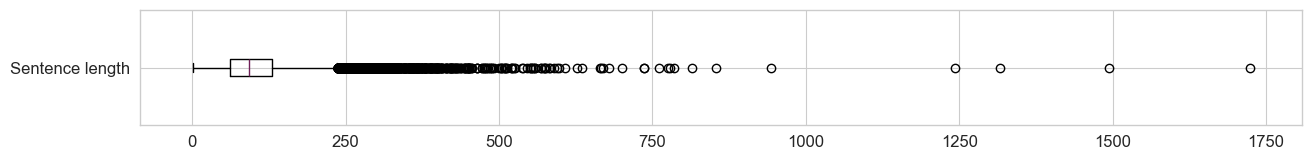

In [ ]:
plt.figure(figsize=(15, 1.5))
plt.boxplot(x=train_sentense_df.sent_len, vert=False, labels=['Sentence length'])
plt.xticks(fontsize=12)
plt.show()

Take away:
- Sentence length was very heavily right skews
- Could potentially suggest outstanding writers right longer sentences
- Extreme data points (passed 750ish characters) could be run-on sentences, implying worse writing caliber

#### 3.3.2 Paragraph Features

We like to extract paragraph level features from the reconstructed essays. The paragraph level features include the mean, standard deviation, min, max, quantiles (including median), standard error of the mean, sum, skewness, and kurtosis.

In [ ]:
train_paragraph_df = split_essays_into_paragraphs(train_essays)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [ ]:
train_paragraph_agg_df

paragraph_count  paragraph_len_mean  paragraph_len_std  \
0                   3          508.000000         134.208793   
1                   6          278.166667          98.554384   
2                   6          429.500000         101.087586   
3                   3          384.000000          56.471232   
4                   5          283.400000         232.336609   
...               ...                 ...                ...   
2466                4          407.750000          91.790976   
2467                6          387.166667         178.941797   
2468                3          918.333333         939.787387   
2469                5          509.600000         122.681702   
2470                6          247.166667         137.836739   

      paragraph_len_min  paragraph_len_max  paragraph_len_first  \
0                   390                654                  390   
1                   176                462                  240   
2                   296                568                  491   
3                   347                449                  347   
4                    23                627                  351   
...                 ...                ...                  ...   
2466                301                514                  372   
2467                144                648                  144   
2468                327               2002                  426   
2469                380                672                  672   
2470                 59                412                   59   

      paragraph_len_last  paragraph_len_sem  paragraph_len_q1  \
0                    480          77.485483            435.00   
1                    284          40.234659            228.75   
2                    296          41.268834            356.75   
3                    356          32.603681            351.50   
4                     23         103.904090            124.00   
...                  ...                ...               ...   
2466                 301          45.895488            354.25   
2467                 228          73.052683            274.00   
2468                2002         542.586501            376.50   
2469                 380          54.864925            394.00   
2470                 224          56.271613            171.50   

      paragraph_len_median  paragraph_len_q3  paragraph_len_skew  \
0                    480.0            567.00            0.897971   
1                    261.0            283.50            1.548347   
2                    444.5            483.50           -0.103767   
3                    356.0            402.50            1.682689   
4                    292.0            351.00            0.636813   
...                    ...               ...                 ...   
2466                 408.0            461.50           -0.012990   
2467                 424.0            450.25           -0.011589   
2468                 426.0           1214.00            1.710452   
2469                 540.0            562.00            0.165516   
2470                 229.5            358.00            0.056536   

      paragraph_len_kurt  paragraph_len_sum  paragraph_word_count_mean  \
0                    NaN               1524                  89.666667   
1               3.107505               1669                  59.166667   
2              -0.970266               2577                  68.333333   
3                    NaN               1152                  69.333333   
4               0.237666               1417                  51.200000   
...                  ...                ...                        ...   
2466           -1.260703               1631                  77.000000   
2467           -0.246018               2323                  73.833333   
2468                 NaN               2755                 615.333333   
2469           -1.573277               2548                  83.400000   
2470           -1.20

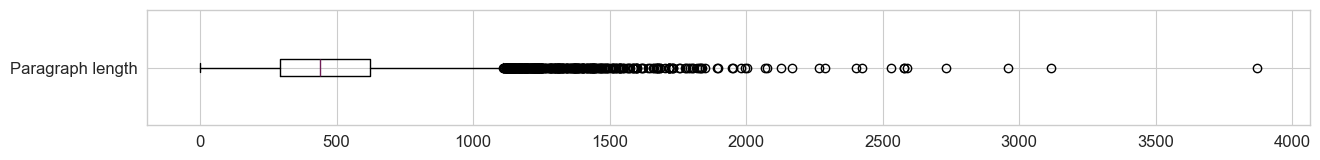

In [ ]:
plt.figure(figsize=(15, 1.5))
plt.boxplot(x=train_paragraph_df.paragraph_len, vert=False, labels=['Paragraph length'])
plt.show()

Take away:
- Similar to sentence structure, there is a heavy right skew in the paragraph length
- Could potentially suggest outstanding writers could have longer, more detailed paragraphs
- Interesting to note that average paragraph length is only around 4 times longer than average sentence length, suggests not many sentences in each paragraph (perhaps due to time constraints while writing?)

#### 3.3.3 Token Features

Since now we have access to the reconstructed essays, we can follow standard Natural Language Processing (NLP) practice, we would like to extract tokenizer matrix and use the matrix as features.

In [ ]:
# Initialize the count vectorizer
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
# Fit and transform the training data
X_tokenizer_train = count_vectorizer.fit_transform(train_essays['essay'])
# Convert the sparse matrix to a dense matrix
X_tokenizer_train = X_tokenizer_train.todense()
# Add the feature names to the dataframe
train_token_df = pd.DataFrame()
for i in range(X_tokenizer_train.shape[1]) :
    L = list(X_tokenizer_train[:,i])
    li = [int(x) for x in L ]
    train_token_df[f'feature {i}'] = li
train_token_df.loc[:, 'id'] = train_essays['id']

In [ ]:
train_token_df

feature 0  feature 1  feature 2  feature 3  feature 4  feature 5  \
0            53          8         12          8          6          8   
1            61          8         12         19         11          5   
2            64          6          8          8          6          6   
3            44          6          7          8          4          6   
4            49          3         15         11          9          2   
...         ...        ...        ...        ...        ...        ...   
2466         49          5          4          9         13          7   
2467         74         16          9         21         10          7   
2468         42          5          9          8          7          5   
2469         80          5         19         12         11          6   
2470         47          5          5         10          4          4   

      feature 6  feature 7  feature 8  feature 9  feature 10  feature 11  \
0             1          4          4          2           0           0   
1             1          1          0          1           2           0   
2             4         10          4          4           8           0   
3             6          1          1          2           0           1   
4             3          3          0          1           2           0   
...         ...        ...        ...        ...         ...         ...   
2466          7          0          1          0           0           3   
2467          4          4          1          1           0           1   
2468          3          1          1          1           1           0   
2469         11          2          1          5           5           2   
2470          3          2          5          1           7           0   

      feature 12  feature 13  feature 14  feature 15  feature 16  feature 17  \
0              0           0           0           0           0           0   
1              1           0           0           0           0           0   
2              0           0           0           0           0           0   
3              2           0           0           0           0           0   
4              0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
2466           0           0           0           0           0           0   
2467           0           0           0           0           0           0   
2468           0           1           0           0           0           0   
2469           1           0           0           0           0           0   
2470           1           0           0           0           0           0   

      feature 18  feature 19  feature 20  feature 21  feature 22  feature 23  \
0              0           0           0           0          46           6   
1              0           0           0           0          88          11   
2              0           0           0           0          70           7   
3              0           0           0           0          31           7   
4              0           0           0           0          61          11   
...          ...         ...         ...         ...         ...         ...   
2466           0           0           0           0          39           5   
2467           0           0           0           0          78           8   
2468           0           0           0           0          44           6   
2469           0           0           0           0          72          12   
2470           0           0           0           0          33           8   

      feature 24  feature 25  feature 26  feature 27  feature 28  feature 29  \
0              6           2           8           5           6           3   
1             27          16          13          10           3           3   
2              8          13           9  

In [ ]:
# Merge train_feats, train_sentense_agg_df, train_paragraph_agg_df, and train_token_df using pandasql
query = '''
SELECT t.*, s.*, p.*, tok.*
FROM train_feats AS t
LEFT JOIN train_sentense_agg_df AS s ON t.id = s.id
LEFT JOIN train_paragraph_agg_df AS p ON t.id = p.id
LEFT JOIN train_token_df AS tok ON t.id = tok.id
'''
train_feats = ps.sqldf(query, locals())

# remove duplicate 'id' columns
train_feats = train_feats.loc[:,~train_feats.columns.duplicated()]
train_feats = remove_collinear_features(train_feats, 0.95)
train_df_v2 = train_feats.copy()

In [ ]:
train_df_v2

id  event_id_max  up_time_max  action_time_max  action_time_min  \
0     001519c8          2557      1801969             2259                0   
1     0022f953          2454      1788969             1758                0   
2     0042269b          4136      1771669             3005                0   
3     0059420b          1556      1404469              806                0   
4     0075873a          2531      1662472              701                0   
...        ...           ...          ...              ...              ...   
2466  ffb8c745          4739      1791649             3323                0   
2467  ffbef7e5          2604      1799174             1144                0   
2468  ffccd6fd          3063      1959363              564                0   
2469  ffec5b38          3242      1508504             1388                0   
2470  fff05981          3619      2070133             1915                0   

      action_time_mean  action_time_std  action_time_quantile  \
0           116.246774        91.797374                 112.0   
1           112.221271        55.431189                 115.0   
2           101.837766        82.383766                  94.0   
3           121.848329       113.768226                 110.0   
4           123.943896        62.082013                 129.0   
...                ...              ...                   ...   
2466        105.437856        63.622575                 113.0   
2467         82.266129        36.178818                  80.0   
2468         75.605615        63.494975                  70.0   
2469         89.277915        54.515788                  85.0   
2470         83.237082        63.738723                  84.0   

      action_time_sem  action_time_sum  action_time_skew  action_time_kurt  \
0            1.815369           297243         12.546928        218.650155   
1            1.118966           275391         10.902216        318.756986   
2            1.281007           421201         16.611183        447.265001   
3            2.884139           189596          2.426886          7.249040   
4            1.234013           313702          1.890640         12.709323   
...               ...              ...               ...               ...   
2466         0.924204           499670         27.963932       1385.103205   
2467         0.708980           214221         10.200466        292.128436   
2468         1.147271           231580          3.696536         21.515363   
2469         0.957449           289439          9.407437        180.915739   
2470         1.059520           301235         13.743123        314.955334   

      activity_nunique  down_event_nunique  up_event_nunique  \
0                    7                  12                12   
1                    5                  17                17   
2                    4                  13                18   
3                    5                  15                15   
4                    3                  11                11   
...                ...                 ...               ...   
2466                 4                  13                13   
2467                 4                  11                11   
2468                 3                  11                11   
2469                 3                  15                15   
2470                 6                  23                24   

      text_change_nunique  cursor_position_nunique  cursor_position_max  \
0                      17                     1469                 1539   
1                      12                     1416                 1676   
2                      19                     1649                 2291   
3                      10                     1048                 1047   
4                       9                     1197                 1402   
...                   ...                      ...                  ...   
2466                   13                     1484 

In [ ]:
# Save
train_df_v2.reset_index(drop=True, inplace=True)
train_df_v2.to_csv(f'{INPUT_DIR}/train_df_v2.csv', index=False)

We will call it version 2 of our dataset.

### 3.4 Space Features

From [this paper](https://files.eric.ed.gov/fulltext/ED592674.pdf), we want to extract information about the pauses that occur during the writing process. We extract pauses between actions at 0.5 second intervals and make each pause length a new feature. Broadly speaking, we expect pause length to give insight into how confident a writer is, with longer pauses potentially indicating less clarity of thought while writing.

In [ ]:
# Idea is based on features introduced in Section 3 of this research paper: https://files.eric.ed.gov/fulltext/ED592674.pdf

train_logs['up_time_lagged'] = train_logs.groupby('id')['up_time'].shift(1).fillna(train_logs['down_time'])
train_logs['time_diff'] = abs(train_logs['down_time'] - train_logs['up_time_lagged']) / 1000

group = train_logs.groupby('id')['time_diff']
largest_lantency = group.max()
smallest_lantency = group.min()
median_lantency = group.median()
initial_pause = train_logs.groupby('id')['down_time'].first() / 1000
pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
pauses_3_sec = group.apply(lambda x: (x > 3).sum())

train_eD592674 = pd.DataFrame({
    'id': train_logs['id'].unique(),
    'largest_lantency': largest_lantency,
    'smallest_lantency': smallest_lantency,
    'median_lantency': median_lantency,
    'initial_pause': initial_pause,
    'pauses_half_sec': pauses_half_sec,
    'pauses_1_sec': pauses_1_sec,
    'pauses_1_half_sec': pauses_1_half_sec,
    'pauses_2_sec': pauses_2_sec,
    'pauses_3_sec': pauses_3_sec,
}).reset_index(drop=True)

In [ ]:
train_eD592674

id  largest_lantency  smallest_lantency  median_lantency  \
0     001519c8           154.136                0.0            0.062   
1     0022f953           145.899                0.0            0.061   
2     0042269b           153.886                0.0            0.040   
3     0059420b           101.690                0.0            0.131   
4     0075873a           110.688                0.0            0.059   
...        ...               ...                ...              ...   
2466  ffb8c745           128.570                0.0            0.034   
2467  ffbef7e5           267.869                0.0            0.172   
2468  ffccd6fd           229.804                0.0            0.116   
2469  ffec5b38           127.733                0.0            0.091   
2470  fff05981           137.607                0.0            0.097   

      initial_pause  pauses_half_sec  pauses_1_sec  pauses_1_half_sec  \
0             4.526              114            51                 30   
1            30.623              141            37                 13   
2             4.441               83            46                 25   
3            41.395              178            81                 34   
4            78.470               65            24                 11   
...             ...              ...           ...                ...   
2466         22.467              117            41                 18   
2467         21.732              121            43                 24   
2468         23.482              168            82                 37   
2469         19.885              116            35                 27   
2470         39.727              266            94                 46   

      pauses_2_sec  pauses_3_sec  
0               21           103  
1               19            61  
2               25            52  
3               32            55  
4               17            71  
...            ...           ...  
2466            11            30  
2467            24            66  
2468            29            58  
2469            15            48  
2470            38            82  

[2471 rows x 10 columns]

In [ ]:
query = '''
SELECT t.*, e.*
FROM train_feats AS t
LEFT JOIN train_eD592674 AS e ON t.id = e.id
'''
train_feats = ps.sqldf(query, locals())
train_feats = remove_collinear_features(train_feats, 0.95)
train_df_v3 = train_feats.copy()

In [ ]:
train_df_v3

id  event_id_max  up_time_max  action_time_max  action_time_min  \
0     001519c8          2557      1801969             2259                0   
1     0022f953          2454      1788969             1758                0   
2     0042269b          4136      1771669             3005                0   
3     0059420b          1556      1404469              806                0   
4     0075873a          2531      1662472              701                0   
...        ...           ...          ...              ...              ...   
2466  ffb8c745          4739      1791649             3323                0   
2467  ffbef7e5          2604      1799174             1144                0   
2468  ffccd6fd          3063      1959363              564                0   
2469  ffec5b38          3242      1508504             1388                0   
2470  fff05981          3619      2070133             1915                0   

      action_time_mean  action_time_std  action_time_quantile  \
0           116.246774        91.797374                 112.0   
1           112.221271        55.431189                 115.0   
2           101.837766        82.383766                  94.0   
3           121.848329       113.768226                 110.0   
4           123.943896        62.082013                 129.0   
...                ...              ...                   ...   
2466        105.437856        63.622575                 113.0   
2467         82.266129        36.178818                  80.0   
2468         75.605615        63.494975                  70.0   
2469         89.277915        54.515788                  85.0   
2470         83.237082        63.738723                  84.0   

      action_time_sem  action_time_sum  action_time_skew  action_time_kurt  \
0            1.815369           297243         12.546928        218.650155   
1            1.118966           275391         10.902216        318.756986   
2            1.281007           421201         16.611183        447.265001   
3            2.884139           189596          2.426886          7.249040   
4            1.234013           313702          1.890640         12.709323   
...               ...              ...               ...               ...   
2466         0.924204           499670         27.963932       1385.103205   
2467         0.708980           214221         10.200466        292.128436   
2468         1.147271           231580          3.696536         21.515363   
2469         0.957449           289439          9.407437        180.915739   
2470         1.059520           301235         13.743123        314.955334   

      activity_nunique  down_event_nunique  up_event_nunique  \
0                    7                  12                12   
1                    5                  17                17   
2                    4                  13                18   
3                    5                  15                15   
4                    3                  11                11   
...                ...                 ...               ...   
2466                 4                  13                13   
2467                 4                  11                11   
2468                 3                  11                11   
2469                 3                  15                15   
2470                 6                  23                24   

      text_change_nunique  cursor_position_nunique  cursor_position_max  \
0                      17                     1469                 1539   
1                      12                     1416                 1676   
2                      19                     1649                 2291   
3                      10                     1048                 1047   
4                       9                     1197                 1402   
...                   ...                      ...                  ...   
2466                   13                     1484 

In [ ]:
# save
train_df_v3.reset_index(drop=True, inplace=True)
train_df_v3.to_csv(f'{INPUT_DIR}/train_df_v3.csv', index=False)

We will call it version 3 of our dataset.

<!-- give me 3 column table -->

##### Table 1: Dataset Versioning
| Version | Statistics Features | Frequency Features | Essay Features | Space Features |
| --- | --- | --- | --- | --- |
| 1 | Yes | Yes | No | No |
| 2 | Yes | Yes | Yes | No |
| 3 | Yes | Yes | Yes | Yes |

We know that with 4 different features we technically can have $2^4 = 16$ different combinations of features. However, we only have 3 different versions of our dataset because the models we're using are able to perform feature selection. However, it maybe true that few features may provide the model a easier landscape to learn, which may lead to better performance, but we will leave the ablation study of 16 different combinations of features to the future work.

## Part 4: Data Synthesis

In Part 3.3, we have mentioned about the essay features for each essay after we reconstruct the essay from the user logs. Having seen the training data being 2,471 only, which is obvisouly not enough for training a model with high complexity, we've been the need of more data. In addition, the data distribution of the training data is not balanced (i.e., there are more average writers than good or bad writers), we're expecting all models to perform slightly poorly on the extreme writers.

I believe we've heard of LLM would perform great at SAT, which yields a unique oppotunity for us to generate more data. If we design the prompt carefully with its official description of rubric, and a score we hope the genreated essay would get, we can generate a lot of essays! By playing with the temperature, we can allow the model to be more "creative" so that we will never get the same essay twice.

However, a downside of this approach is that for the additional data we would only have the essay features but not all the other features. It's not too big of a problem because we can use models that knows how to handle missing values, and we can also design a neural network that takes dual inputs (i.e., essay features and other features).

In [ ]:
SAT_RUBRIC = {
    1: """
        Description: An essay in this category demonstrates very little or no mastery and is severely flawed by one or more weaknesses.
        Key Points:
        - No viable point of view or little evidence to support its position.
        - Disorganized or unfocused, resulting in a disjointed essay.
        - Fundamental errors in vocabulary.
        - Severe flaws in sentence structure.
        - Pervasive errors in grammar, usage, or mechanics that interfere with meaning.
    """,
    2: """
        Description: An essay in this category demonstrates little mastery and is flawed by one or more weaknesses.
        Key Points:
        - Vague or seriously limited point of view with weak critical thinking.
        - Poorly organized and/or focused.
        - Very little facility in the use of language, with very limited vocabulary.
        - Frequent problems in sentence structure.
        - Serious errors in grammar, usage, and mechanics that obscure meaning.
    """,
    3: """
        Description:An essay in this category demonstrates developing mastery and has one or more weaknesses.
        Key Points:
        - Develops a point of view but may be inconsistent or use inadequate examples.
        - Limited organization or focus, with lapses in coherence.
        - Developing use of language, with weak vocabulary at times.
        - Lacks variety or has problems in sentence structure.
        - Accumulation of grammar, usage, and mechanics errors.
    """,
    4: """
        Description: An essay in this category demonstrates adequate mastery, but has lapses in quality.
        Key Points:
        - Develops a point of view with competent critical thinking.
        - Generally organized and focused.
        - Adequate but inconsistent use of language and vocabulary.
        - Some variety in sentence structure.
        - Has some errors in grammar, usage, and mechanics.
    """,
    5: """
        Description: An essay in this category demonstrates reasonably consistent mastery, with occasional errors or lapses in quality.
        Key Points:
        - Effectively develops a point of view.
        - Demonstrates strong critical thinking with appropriate examples.
        - Well organized and focused.
        - Good use of language and appropriate vocabulary.
        - Variety in sentence structure.
        - Generally free of most grammar, usage, and mechanics errors.
    """,
    6: """
        Description: An essay in this category demonstrates clear and consistent mastery, although it may have a few minor errors.
        Key Points:
        - Effectively and insightfully develops a point of view.
        - Demonstrates outstanding critical thinking with clear examples.
        - Well organized, clear focus, smooth progression of ideas.
        - Skillful use of language and varied vocabulary.
        - Meaningful variety in sentence structure.
        - Free of most grammar, usage, and mechanics errors.
    """,
}

SAT_PROMPT = [
    """
    While some people promote competition as the only way to achieve success, others emphasize the power of cooperation. Intense rivalry at work or play or engaging in competition involving ideas or skills may indeed drive people either to avoid failure or to achieve important victories. In a complex world, however, cooperation is much more likely to produce significant, lasting accomplishments.
    Do people achieve more success by cooperation than by competition?
    """,
    """
    Sometimes it is necessary to challenge what people in authority claim to be true. Although some respect for authority is, no doubt, necessary in order for any group or organization to function, questioning the people in charge-even if they are experts or leaders in their fields-makes us better thinkers. It forces all concerned to defend old ideas and decisions and to consider new ones. Sometimes it can even correct old errors in thought and put an end to wrong actions.
    Is it important to question the ideas and decisions of people in positions of authority?
    """,
    """
    We don't really learn anything properly until there is a problem, until we make a mistake, until something fails to go as we had hoped. When everything is working well, with no problems or failures, what incentive do we have to try something new? We are only motivated to learn when we experience difficulties.
    Does true learning only occur when we experience difficulties
    """,
    """
    There are two kinds of pretending. There is the bad kind, as when a person falsely promises to be your friend. But there is also a good kind, where the pretense eventually turns into the real thing. For example, when you are not feeling particularly friendly, the best thing you can do, very often, is to act in a friendly manner. In a few minutes, you may really be feeling friendlier.
    Can deception—pretending that something is true when it is not—sometimes have good results?
    """
]

In [ ]:
model = ChatOpenAI(
    openai_api_key = os.environ["OPENAI_API_KEY"], # Get your API key from OpenAI
    model_name = "gpt-4-1106-preview", # switch to "gpt-3.5-turbo-1106" for cheaper price
    temperature=1.0, # Important to get diverse responses
    request_timeout=30,
    max_retries=10,
)

prompt = ChatPromptTemplate.from_messages([
  SystemMessage(content="""
    You're a helpful assistant who helps me write an SAT essay given a prompt, a score of 1-6, and the criteria for that score.
    The essay should be least 200 words in 3 paragraphs and they should not use any online or offline reference materials.
    The essay should be finished in 30 minutes.
    """),
  HumanMessagePromptTemplate.from_template("""
        Prompt: {prompt},
        Score: {score},
        Description of score: {description},
    """),
])

chain = prompt | model

In [ ]:
NUM_ESSAYS = 1000

prompt_id_list = []
score_list = []
essay_list = []

for i in tqdm(range(NUM_ESSAYS)):
    prompt_id = np.random.randint(0, len(SAT_PROMPT))
    score = np.random.randint(1, 7)

    ret = chain.invoke({
        "prompt": SAT_PROMPT[prompt_id],
        "score": score,
        "description": SAT_RUBRIC[score]
    })

    prompt_id_list.append(prompt_id)
    score_list.append(score)
    essay_list.append(ret.content)

essay_df = pd.DataFrame({
    "prompt_id": prompt_id_list,
    "score": score_list,
    "essay": essay_list
})

In [ ]:
# Since the LLM generator takes a long time to run, we will save the output as a csv file and load it here.
llm_train_df = pd.read_csv(f'{INPUT_DIR}/llm_essays.csv')

In [ ]:
llm_train_df

prompt_id  score                                              essay
0            1      6  The intrinsic value of questioning authority l...
1            3      1  Pretending can be said to have two types. Some...
2            2      2  True learning is when we face problems and hav...
3            0      5  Title: Cooperation vs. Competition: The Path t...
4            2      1  The idea that we only learn from mistakes is i...
..         ...    ...                                                ...
594          3      4  Deception is largely chastised for its negativ...
595          0      2  Success, a highly sought-after aspiration, is ...
596          1      5  The notion of challenging authority has been a...
597          1      5  Title: Questioning Authority: A Catalyst for P...
598          2      6  Title: Embracing Difficulty: The True Teacher\...

[599 rows x 3 columns]

In [ ]:
# replace all alphanumeric character in llm_train_df['essay'] with 'q' besides '\n'
llm_train_df['essay'] = llm_train_df['essay'].str.replace('[a-zA-Z0-9]', 'q')
# keep the useful columns
llm_train_df = llm_train_df[['essay', 'score']]
llm_train_df['id'] = llm_train_df.index

# extract sentences and paragraphs from essays
llm_train_sentense_df = split_essays_into_sentences(llm_train_df)
llm_train_sentense_agg_df = compute_sentence_aggregations(llm_train_sentense_df)
llm_train_paragraph_df = split_essays_into_paragraphs(llm_train_df)
llm_train_paragraph_agg_df = compute_paragraph_aggregations(llm_train_paragraph_df)

llm_train_df = llm_train_df.merge(llm_train_sentense_agg_df, on='id', how='left')
llm_train_df = llm_train_df.merge(llm_train_paragraph_agg_df, on='id', how='left')

llm_train_df.drop(['essay', 'sent', 'paragraph'], axis=1, inplace=True)

In [ ]:
llm_train_df

score   id  sent_count  sent_len_mean  sent_len_std  sent_len_min  \
0        6    0          13     170.461538     80.025637            76   
1        1    1          14      55.571429     19.516125            28   
2        2    2          12      80.500000     30.652006            33   
3        5    3          16     167.687500     56.590598            21   
4        1    4          13      80.461538     23.799914            42   
..     ...  ...         ...            ...           ...           ...   
594      4  594          17     134.411765     36.544594            65   
595      2  595          17     109.000000     40.084286            44   
596      5  596          18     130.611111     37.722109            91   
597      5  597          17     151.882353     37.235538            88   
598      6  598          17     143.411765     40.786117            67   

     sent_len_max  sent_len_first  sent_len_last  sent_len_sem  sent_len_q1  \
0             325             105            191     22.195118       105.00   
1              91              40             44      5.215904        41.00   
2             146              75             71      8.848472        69.75   
3             265              21            174     14.147650       152.75   
4             118              56             95      6.600908        64.00   
..            ...             ...            ...           ...          ...   
594           191             130            191      8.863366       121.00   
595           184             100            171      9.721867        86.00   
596           203              91            203      8.891186        99.75   
597           246             246            181      9.030944       129.00   
598           204             135            172      9.892086       113.00   

     sent_len_median  sent_len_q3  sent_len_skew  sent_len_kurt  sent_len_sum  \
0              148.0       207.00       0.636408      -0.694461          2216   
1               47.5        70.25       0.650157      -0.696787           778   
2               76.0        93.75       0.548838       0.941693           966   
3              172.0       198.25      -0.974931       2.310908          2683   
4               78.0       100.00      -0.019059      -1.035551          1046   
..               ...          ...            ...            ...           ...   
594            132.0       156.00      -0.340043      -0.423009          2285   
595            100.0       142.00       0.527233      -0.605953          1853   
596            118.0       162.75       0.662446      -1.075213          2351   
597            149.0       166.00       0.812688       1.478625          2582   
598            153.0       174.00      -0.496734      -0.905976          2438   

     sent_word_count_mean  sent_word_count_std  sent_word_count_min  \
0               25.846154            12.595278                   12   
1               11.071429             4.122439                    5   
2               16.000000             6.564367                    5   
3               24.625000             7.965551                    3   
4               14.846154             4.412976                    8   
..                    ...                  ...                  ...   
594             19.882353             5.543942                   10   
595             16.647059             6.412304                    6   
596             19.944444             5.895883                   14   
597             22.941176             6.067028                   13   
598             22.764706             6.814776                   11   

     sent_word_count_max  sent_word_count_first  sent_word_count_last  \
0                     52                     15                    31   
1                     19                      8                     8   
2                     30                     16                    14   
3                     39                      3  

In [ ]:
train_df_v4 = pd.concat([train_df_v3, llm_train_df], axis=0).reset_index(drop=True)
train_df_v4 = remove_collinear_features(train_df_v4, 0.95)

In [ ]:
# save
train_df_v4.reset_index(drop=True, inplace=True)
train_df_v4.to_csv(f'{INPUT_DIR}/train_df_v4.csv', index=False)

In [ ]:
INPUT_DIR= '/content/drive/MyDrive/BigData/linking-writing-processes-to-writing-quality'

In [ ]:
# Optinal: load all datasets
train_df_v1 = pd.read_csv(f'{INPUT_DIR}/train_df_v1.csv')
train_df_v2 = pd.read_csv(f'{INPUT_DIR}/train_df_v2.csv')
train_df_v3 = pd.read_csv(f'{INPUT_DIR}/train_df_v3.csv')
train_df_v4 = pd.read_csv(f'{INPUT_DIR}/train_df_v4.csv')

## Part 5: Modeling

### 5.1 Linear Regression

Linear regression is a linear approach to modeling the relationship between a scalar response and one or more explanatory variables. We plan to use linear regression as our baseline model.

### 5.1.1 Linear Regression Hyperparameter Tuning

There are many different parameters and adjustments to the base linear regression model which can lead to better results. Here, we use sklearn's GridSearchCV to test Linear Regression models with Ridge, Lasso, and ElasticNet regularization with varying parameters.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, PredefinedSplit

from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
# models and parameters for GridSearch
regrs = {
    'LR': (
        LinearRegression(),
        {},
    ),
    'Ridge': (
        Ridge(),
        {'alpha': np.exp(np.linspace(-4, 4, 9))},
    ),
    'Lasso': (
        Lasso(),
        {'alpha': np.exp(np.linspace(-4, 4, 9))},
    ),
    'ElasticNet': (
        ElasticNet(),
        {"alpha": [0.1, 0.2, 0.5, 1], "l1_ratio": [0.1, 0.2, 0.5, 1]},
    ),
}

In [ ]:
# datasets to train on and their names
datasets = {'train_df_v1': train_df_v1, 'train_df_v2': train_df_v2, 'train_df_v3': train_df_v3}

In [ ]:
def crossvalidate_record(datasets = datasets, algos=regrs, scores='neg_root_mean_squared_error'):
    df = pd.DataFrame()
    for train_df_name, train_df in datasets.items():

      # move score column to last column and replace nan values
      score = train_df.pop("score")
      train_df.insert(len(train_df.columns), "score", score)
      train_df = train_df.replace([np.inf, -np.inf], np.nan)
      train_df = train_df.fillna(train_df.mean())
      train_df = train_df.drop(columns=['id'])

      # GridSearch
      for name, (algo, params) in algos.items():
          cv = GridSearchCV(
              algo,
              params,
              scoring=scores,
              n_jobs=-1,
              refit=False,
              cv=4,
          )
          cv.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])
          headers = [
              name for name in cv.cv_results_.keys()
                  if name.startswith('param_') or name.startswith('mean_test_') or name.startswith('std_test_')
          ]
          results = pd.DataFrame(cv.cv_results_)[headers]
          results['regressor'] = name
          results['data'] = train_df_name
          df = pd.concat((df, results), sort=False)
    return df.reindex(sorted(df.columns), axis=1)

In [ ]:
# formatting results
results = crossvalidate_record()
results = results.rename(columns={'mean_test_score' : 'root_mean_squared_error'})
results = results.drop(columns=['std_test_score'])
results = results.sort_values(by = "root_mean_squared_error", ascending = False)
results = results.reset_index(drop=True)
results["root_mean_squared_error"] = results["root_mean_squared_error"].apply(lambda x: abs(x))
results = results.fillna(value="")
results

<ipython-input-125-2ba88996ffdb>:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df = train_df.fillna(train_df.mean())
<ipython-input-125-2ba88996ffdb>:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df = train_df.fillna(train_df.mean())
<ipython-input-125-2ba88996ffdb>:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_on

data  root_mean_squared_error param_alpha param_l1_ratio  \
0    train_df_v3                 0.689982         0.5              1   
1    train_df_v3                 0.689989           1            0.5   
2    train_df_v3                 0.691978           1              1   
3    train_df_v3                 0.691978         1.0                  
4    train_df_v2                 0.691983         1.0                  
..           ...                      ...         ...            ...   
100  train_df_v3                 0.850699    0.049787                  
101  train_df_v3                 0.860779    0.018316                  
102  train_df_v1                 0.928931                              
103  train_df_v2                 1.034265                              
104  train_df_v3                 1.850873                              

      regressor  
0    ElasticNet  
1    ElasticNet  
2    ElasticNet  
3         Lasso  
4         Lasso  
..          ...  
100       Ridge  
101       Ridge  
102          LR  
103          LR  
104          LR  

[105 rows x 5 columns]

From our hyperparameter tuning, we see that ElasticNet on train_df_v3 provides the best fit with a root_mean_squared_error of 0.689982 using alpha=0.5 and l1=1. We will now use these hyperparameters to run ElasticNet again.

### 5.1.2 Linear Regression with Best Parameters




In [ ]:
ret_scores = []
# Linear regression cannot handle NaN values, so we didn't include v4 here
for train_df in [train_df_v1, train_df_v2, train_df_v3]:
    train_df = train_df.copy()

    # replace inf, -inf, nan with mean
    train_df = train_df.replace([np.inf, -np.inf], np.nan)
    train_df = train_df.fillna(train_df.mean())
    target_col = ['score']
    drop_cols = ['id']
    train_cols = [col for col in train_df.columns if col not in target_col + drop_cols]

    val_preds = np.zeros(train_df.shape[0], )
    models_dict = {}

    kf = KFold(n_splits=10, shuffle=False)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
        print("==-"* 50)
        print("Fold : ", fold)

        X_train, y_train = train_df[train_cols].iloc[train_idx], train_df[target_col].iloc[train_idx]
        X_valid, y_valid = train_df[train_cols].iloc[valid_idx], train_df[target_col].iloc[valid_idx]

        # Data Augmentation


        print("Train shape : ", X_train.shape)
        print("Valid shape : ", X_valid.shape)

        # Logistic Regression
        model = ElasticNet(alpha=0.5, l1_ratio=1)

        model.fit(X_train, y_train)

        val_preds[valid_idx] = model.predict(X_valid).squeeze()

        models_dict[fold] = model

    # 10-fold cross validation RMSE
    ret_scores.append(round(mean_squared_error(train_df[target_col], val_preds, squared=False), 4))
    # print(f"Linear Regression Score: {mean_squared_error(train_df[target_col], val_preds, squared=False)}")


==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Train shape :  (2223, 286)
Valid shape :  (248, 286)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Train shape :  (2224, 286)
Valid shape :  (247, 286)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  2
Train shape :  (2224, 286)
Valid shape :  (247, 286)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  3
Train shape :  (2224, 286)
Valid shape :  (247, 286)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-

In [ ]:
print("Linear Regression")
for idx, ret_score in enumerate(ret_scores):
    print(f"On dataset version {idx + 1}, the RMSE is {ret_score}")

Linear Regression
On dataset version 1, the RMSE is 0.7203
On dataset version 2, the RMSE is 0.6824
On dataset version 3, the RMSE is 0.6805


Take away:
The RMSE is significantly higher than that of the models seen below. The reasoning behind it could be the following:

*   Linear regression cannot handle infinite or NAN values; hence, some sort of data imputation has to be done. In our case, we imputed the infinite and the missing values as mean values.This did not produce results as accurate as with other models.
*   Linear regression does not account for nonlinear relationships. For example, the sum of sentences feature could have nonlinear relationship with score, but the linear regression did not capture it. The degree of nonlinearity cannot be tested for each feature as it would lead to computational complexity.
*    Linear regression necessitates an assumption diagnotic, which checks for violation of assumptions; however, because of time constraints and the amount of features, it was unresonable to conduct a diagnotic.






### 5.2 Light Gradient Boosting Machine

LightGBM or Light Gradient Boosting Machine is a gradient boosting ensemble method based on decision trees that offers extremely fast computation and increased performance on sparser datasets. It utilizes Gradient Based One-Side Sampling which selects a subset of the data to train on based on how large the gradient of that data is. By keeping data with larger gradients, LGBM is able to correct itself on sparser, poorly trained datapoints. This is useful for out dataset because of the lack of extremely good or extremely bad essays. LGBM also uses a technique called Exclusive Feature Bundling (EFB) which reduces feature dimensionality by combining features with no overlapping non-zero values accross every datapoint. This improves training time with very wide datasets as seen in our various train_df version.

### 5.2.1 LightGBM Hyperparameter Tuning

Here we do hyperparameter tuning for LGBM to decide which parameters we should choose.

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import mean_squared_error
import optuna

for train_df in [train_df_v1, train_df_v2, train_df_v3, train_df_v4]:
  train_df = train_df.copy()

  target_col = ['score']
  drop_cols = ['id']
  train_cols = [col for col in train_df.columns if col not in target_col + drop_cols]

  #decide if the dataset contains llm data

  with_llm_data = False
  if train_df.shape[0] > 2471:
    with_llm_data = True
    llm_train_df = train_df.iloc[2471:,:]
    train_df = train_df.iloc[:2471, :]

  val_preds = np.zeros(train_df.shape[0],)
  models_dict = {}

  X_train, y_train = train_df[train_cols].iloc[:2000], train_df[target_col].iloc[:2000]
  X_valid, y_valid = train_df[train_cols].iloc[2000:], train_df[target_col].iloc[2000:]

  if with_llm_data:
      X_llm, y_llm = llm_train_df[train_cols], llm_train_df[target_col]
      X_train = np.concatenate([X_train, X_llm], axis = 0)
      y_train = np.concatenate([y_train, y_llm], axis = 0)

  print("Train shape : ", X_train.shape)
  print("Valid shape : ", X_valid.shape)

  def objective1(trial):
    params = {
          "objective": "regression",
          "metric": "rmse",
          "n_estimators": 10000,
          "boosting_type": "gbdt",
          "seed": random_seed,
          "force_col_wise": True,
          'max_depth': trial.suggest_int("max_depth", 5, 10),
          'num_leaves': trial.suggest_int("num_leaves", 5, 15),
          'feature_fraction': trial.suggest_float("feature_fraction", 0.05, 0.15),
          'subsample': trial.suggest_float("subsample", 0.8, 0.9),
          "learning_rate": trial.suggest_float("learning_rate", 0.0075, 0.0125),
          "lambda_l1": trial.suggest_int("lambda_l1", 0, 2)
          }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    return rmse

  study = optuna.create_study(direction='minimize')
  study.optimize(objective1, n_trials=15)



In [ ]:
#Best Hyperparameters for each train data set obtained using hyperparameter tuning by optuna:
#Train Df 1: Trial 8 finished with value: 0.6477320115292262 and parameters: {'max_depth': 8, 'num_leaves': 8, 'feature_fraction': 0.12320979165248105, 'subsample': 0.8160065802797184, 'learning_rate': 0.009366973103158864, 'lambda_l1': 1}. Best is trial 8 with value: 0.6477320115292262.
#Train Df 2: Trial 3 finished with value: 0.6193358774563008 and parameters: {'max_depth': 7, 'num_leaves': 7, 'feature_fraction': 0.13788629443230033, 'subsample': 0.8437782455885032, 'learning_rate': 0.008744551859187558, 'lambda_l1': 1}. Best is trial 3 with value: 0.6193358774563008.
#Train Df 3: Trial 14 finished with value: 0.6173428755120386 and parameters: {'max_depth': 6, 'num_leaves': 10, 'feature_fraction': 0.05216912898514858, 'subsample': 0.814757441473463, 'learning_rate': 0.011693159899142469, 'lambda_l1': 0}. Best is trial 14 with value: 0.6173428755120386.
#Train Df 4: Trial 1 finished with value: 0.6160279191447041 and parameters: {'max_depth': 10, 'num_leaves': 14, 'feature_fraction': 0.14212600833187738, 'subsample': 0.8712630866252725, 'learning_rate': 0.008940825488729405, 'lambda_l1': 1}. Best is trial 1 with value: 0.6160279191447041.

### 5.2.2 LightGBM with Best Parameters



We define the parameters which worked best found by hyperparameter tuning and test them more rigorously.

In [40]:
# Parameters found from Hyperparameter Tuning
params_list = [{
  "objective": "regression",
  "metric": "rmse",
  "n_estimators": 10000,
  "boosting_type": "gbdt",
  "seed": random_seed,
  "force_col_wise": True,
  'max_depth': 8,
  'num_leaves': 8,
  'feature_fraction': 0.123,
  'subsample': 0.816,
  "learning_rate": 0.00936,
  "lambda_l1": 1
  },
            {
  "objective": "regression",
  "metric": "rmse",
  "n_estimators": 10000,
  "boosting_type": "gbdt",
  "seed": random_seed,
  "force_col_wise": True,
  'max_depth': 7,
  'num_leaves': 7,
  'feature_fraction': 0.137,
  'subsample': 0.843,
  "learning_rate": 0.00874,
  "lambda_l1": 1
  },
            {
  "objective": "regression",
  "metric": "rmse",
  "n_estimators": 10000,
  "boosting_type": "gbdt",
  "seed": random_seed,
  "force_col_wise": True,
  'max_depth': 6,
  'num_leaves': 10,
  'feature_fraction': 0.0521,
  'subsample': 0.814,
  "learning_rate": 0.0116,
  "lambda_l1": 0
  },
            {
  "objective": "regression",
  "metric": "rmse",
  "n_estimators": 10000,
  "boosting_type": "gbdt",
  "seed": random_seed,
  "force_col_wise": True,
  'max_depth': 10,
  'num_leaves': 14,
  'feature_fraction': 0.142,
  'subsample': 0.871,
  "learning_rate": 0.00894,
  "lambda_l1": 1
  }
            ]

In [42]:
ret_scores = []
counter = 0
for train_df in [train_df_v1, train_df_v2, train_df_v3, train_df_v4]:
    train_df = train_df.copy()

    # Select columns for X, y
    target_col = ['score']
    drop_cols = ['id']
    train_cols = [col for col in train_df.columns if col not in target_col + drop_cols]

    # decide if the dataset contains llm data
    with_llm_data = False
    if train_df.shape[0] > 2471:
        with_llm_data = True
        llm_train_df = train_df.iloc[2471:, :]
        train_df = train_df.iloc[:2471, :]

    val_preds = np.zeros(train_df.shape[0], )
    models_dict = {}

    kf = KFold(n_splits=10, shuffle=False)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
        print("==-"* 50)
        print("Fold : ", fold)

        X_train, y_train = train_df[train_cols].iloc[train_idx], train_df[target_col].iloc[train_idx]
        X_valid, y_valid = train_df[train_cols].iloc[valid_idx], train_df[target_col].iloc[valid_idx]

        if with_llm_data:
            X_llm, y_llm = llm_train_df[train_cols], llm_train_df[target_col]
            X_train = np.concatenate([X_train, X_llm], axis=0)
            y_train = np.concatenate([y_train, y_llm], axis=0)

        print("Train shape : ", X_train.shape)
        print("Valid shape : ", X_valid.shape)

        # LightGBM
        params = params_list[counter]

        model = lgb.LGBMRegressor(**params)

        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        verbose_callback = lgb.log_evaluation(period=100, show_stdv=True)

        model.fit(X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                callbacks=[early_stopping_callback, verbose_callback],
        )

        val_preds[valid_idx] = model.predict(X_valid)

        models_dict[fold] = model

    # 10-fold cross validation RMSE
    ret_scores.append(round(mean_squared_error(train_df[target_col], val_preds, squared=False), 4))
    counter += 1
    # print(f"Light GBM Score: {mean_squared_error(train_df[target_col], val_preds, squared=False)}")


==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Train shape :  (2223, 286)
Valid shape :  (248, 286)
[LightGBM] [Warning] feature_fraction is set=0.123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.123
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.123
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Total Bins 64948
[LightGBM] [Info] Number of data points in the train set: 2223, number of used features: 279
[LightGBM] [Warning] feature_fraction is set=0.123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.123
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Curr

In [43]:
print("Light Gradient Boosting")
for idx, ret_score in enumerate(ret_scores):
    if idx == 3:
        print(f"On dataset version {idx} with LLM data, the RMSE is {ret_score}")
    else:
        print(f"On dataset version {idx + 1}, the RMSE is {ret_score}")

Light Gradient Boosting
On dataset version 1, the RMSE is 0.6297
On dataset version 2, the RMSE is 0.6087
On dataset version 3, the RMSE is 0.6101
On dataset version 3 with LLM data, the RMSE is 0.6088


Takeaway:
*   Performed pretty comparably with CatBoost
*   Ran very fast due to our early stopping condition




### 5.4 CatBoost

CatBoost gets its name from its function, Boosting Categories (CatBoost). CatBoost is a gradient-boosting Machine Learning system that offers solutions for interpreting data that are highly categorical or have a lot of missing data points. CatBoost offers optimum results by using the split-by-popularity method to create symmetrical decision trees. The model reduces processing power and time by grouping features into a single split with only a left and right child.The features could be both categorical and numerical, which are then analyzed at different levels of the tree until the target variable is met. This method regularizes the data, preventing correlations by offering multiple viewpoints on the same data subsets. This gives CatBoost’s predictions more resilience from both overfitting and generlization errors in the training process.


### 5.4.1 CatBoost Hyperparameter Tuning

Here we perform hyperparameter tuning on CatBoost to choose which parameters work best.

In [ ]:
import catboost as cb
from sklearn.metrics import mean_squared_error
import optuna

for train_df in [train_df_v1, train_df_v2, train_df_v3, train_df_v4]:
    train_df = train_df.copy()

    target_col = ['score']
    drop_cols = ['id']
    train_cols = [col for col in train_df.columns if col not in target_col + drop_cols]

    # decide if the dataset contains llm data
    with_llm_data = False
    if train_df.shape[0] > 2471:
        with_llm_data = True
        llm_train_df = train_df.iloc[2471:, :]
        train_df = train_df.iloc[:2471, :]

    val_preds = np.zeros(train_df.shape[0], )
    models_dict = {}

    X_train, y_train = train_df[train_cols].iloc[:2000], train_df[target_col].iloc[:2000]
    X_valid, y_valid = train_df[train_cols].iloc[2000:], train_df[target_col].iloc[2000:]

    if with_llm_data:
        X_llm, y_llm = llm_train_df[train_cols], llm_train_df[target_col]
        X_train = np.concatenate([X_train, X_llm], axis=0)
        y_train = np.concatenate([y_train, y_llm], axis=0)

    print("Train shape : ", X_train.shape)
    print("Valid shape : ", X_valid.shape)

    def objective2(trial):
        early_stop_rounds = 400
        params = {
            "iterations": 1000,
            'bootstrap_type' : 'Bernoulli',
            'random_strength': 1,
            'l2_leaf_reg': 3,
            'loss_function' : 'RMSE',
            'eval_metric' : 'RMSE',
            'max_bin' : 1024,
            'max_ctr_complexity' : 8,
            'model_size_reg' : trial.suggest_int("model_size_reg", 0, 2),
            "learning_rate": trial.suggest_float("learning_rate", 0.0075, 0.0125, log=True),
            "depth": trial.suggest_int("depth", 2, 6),
            "subsample": trial.suggest_float("subsample", 0.8, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 60),
        }

        model = CatBoostRegressor(**params, silent=True)
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, predictions, squared=False)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective2, n_trials=15)

[I 2023-12-11 20:27:49,054] A new study created in memory with name: no-name-d383736f-2e92-4c2e-a1a2-cf05d97528be


Train shape :  (2000, 286)
Valid shape :  (471, 286)


[I 2023-12-11 20:30:34,371] Trial 0 finished with value: 0.6495963165419644 and parameters: {'model_size_reg': 2, 'learning_rate': 0.010360542324315016, 'depth': 4, 'subsample': 0.8586723968149303, 'colsample_bylevel': 0.8626786597275455, 'min_data_in_leaf': 43}. Best is trial 0 with value: 0.6495963165419644.
[I 2023-12-11 20:34:07,477] Trial 1 finished with value: 0.6497335828058293 and parameters: {'model_size_reg': 1, 'learning_rate': 0.01112353742561577, 'depth': 6, 'subsample': 0.9563836797293686, 'colsample_bylevel': 0.5083200844370404, 'min_data_in_leaf': 58}. Best is trial 0 with value: 0.6495963165419644.
[I 2023-12-11 20:35:48,592] Trial 2 finished with value: 0.651638793856659 and parameters: {'model_size_reg': 0, 'learning_rate': 0.008982120800992761, 'depth': 4, 'subsample': 0.837736504750977, 'colsample_bylevel': 0.7534231889738483, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.6495963165419644.
[I 2023-12-11 20:36:14,008] Trial 3 finished with value: 0.65794198

Train shape :  (2000, 631)
Valid shape :  (471, 631)


[I 2023-12-11 21:07:52,822] Trial 0 finished with value: 0.630122865881165 and parameters: {'model_size_reg': 2, 'learning_rate': 0.012193222287091604, 'depth': 2, 'subsample': 0.909728769804279, 'colsample_bylevel': 0.9541106269817835, 'min_data_in_leaf': 30}. Best is trial 0 with value: 0.630122865881165.
[I 2023-12-11 21:09:34,958] Trial 1 finished with value: 0.6277421260281686 and parameters: {'model_size_reg': 2, 'learning_rate': 0.01090789431421157, 'depth': 3, 'subsample': 0.8019405599492969, 'colsample_bylevel': 0.7377291264827954, 'min_data_in_leaf': 24}. Best is trial 1 with value: 0.6277421260281686.
[I 2023-12-11 21:12:46,287] Trial 2 finished with value: 0.6276667085978593 and parameters: {'model_size_reg': 2, 'learning_rate': 0.009053817854771919, 'depth': 4, 'subsample': 0.8462860677858223, 'colsample_bylevel': 0.8115280357604253, 'min_data_in_leaf': 28}. Best is trial 2 with value: 0.6276667085978593.
[I 2023-12-11 21:14:21,765] Trial 3 finished with value: 0.626769825

Train shape :  (2000, 640)
Valid shape :  (471, 640)


[I 2023-12-11 21:48:42,540] Trial 0 finished with value: 0.6265809812821982 and parameters: {'model_size_reg': 0, 'learning_rate': 0.012363606243219609, 'depth': 3, 'subsample': 0.9241482862188661, 'colsample_bylevel': 0.8696347908363395, 'min_data_in_leaf': 43}. Best is trial 0 with value: 0.6265809812821982.
[I 2023-12-11 21:53:41,744] Trial 1 finished with value: 0.6246383164433295 and parameters: {'model_size_reg': 2, 'learning_rate': 0.011655160698623072, 'depth': 6, 'subsample': 0.9370317019912735, 'colsample_bylevel': 0.6322682176473464, 'min_data_in_leaf': 42}. Best is trial 1 with value: 0.6246383164433295.
[I 2023-12-11 22:01:35,584] Trial 2 finished with value: 0.6254653370652128 and parameters: {'model_size_reg': 2, 'learning_rate': 0.0090314834531045, 'depth': 6, 'subsample': 0.9703677550812296, 'colsample_bylevel': 0.8574992937875809, 'min_data_in_leaf': 34}. Best is trial 1 with value: 0.6246383164433295.
[I 2023-12-11 22:04:34,439] Trial 3 finished with value: 0.6265324

Train shape :  (2599, 640)
Valid shape :  (471, 640)


[I 2023-12-11 22:33:43,642] Trial 0 finished with value: 0.628517997129821 and parameters: {'model_size_reg': 2, 'learning_rate': 0.008882480441007494, 'depth': 5, 'subsample': 0.8213548363388519, 'colsample_bylevel': 0.6687996264915426, 'min_data_in_leaf': 47}. Best is trial 0 with value: 0.628517997129821.
[I 2023-12-11 22:39:56,540] Trial 1 finished with value: 0.626333337468242 and parameters: {'model_size_reg': 1, 'learning_rate': 0.010483428304979465, 'depth': 6, 'subsample': 0.913715135400607, 'colsample_bylevel': 0.8693353892832956, 'min_data_in_leaf': 42}. Best is trial 1 with value: 0.626333337468242.
[I 2023-12-11 22:40:31,324] Trial 2 finished with value: 0.6396848955193438 and parameters: {'model_size_reg': 1, 'learning_rate': 0.011773760590090538, 'depth': 2, 'subsample': 0.9997594823128861, 'colsample_bylevel': 0.6646993449211959, 'min_data_in_leaf': 35}. Best is trial 1 with value: 0.626333337468242.
[I 2023-12-11 22:46:25,481] Trial 3 finished with value: 0.62637560246

In [ ]:
#Best Hyperparameters for each train data set obtained using hyperparameter tuning by optuna:

#Train Df 1: Trial 14 finished with value: 0.6460020419619456 and parameters: {'model_size_reg': 2, 'learning_rate': 0.01154266786380146, 'depth': 5, 'subsample': 0.9847021257517511, 'colsample_bylevel': 0.9215356114841875, 'min_data_in_leaf': 51}. Best is trial 14 with value: 0.6460020419619456.
#Train Df 2: Trial 12 finished with value: 0.6240307815415103 and parameters: {'model_size_reg': 2, 'learning_rate': 0.010165734781233563, 'depth': 6, 'subsample': 0.9626694220871503, 'colsample_bylevel': 0.5033065782950665, 'min_data_in_leaf': 52}. Best is trial 12 with value: 0.6240307815415103.
#Train Df 3: Trial 10 finished with value: 0.6236921254026556 and parameters: {'model_size_reg': 1, 'learning_rate': 0.009911803578118914, 'depth': 5, 'subsample': 0.8032914236913952, 'colsample_bylevel': 0.7180469156059754, 'min_data_in_leaf': 22}. Best is trial 10 with value: 0.6236921254026556.
#Train Df 4: Trial 12 finished with value: 0.6218087432412173 and parameters: {'model_size_reg': 2, 'learning_rate': 0.01239810994772414, 'depth': 5, 'subsample': 0.8691492946800451, 'colsample_bylevel': 0.5080627648672564, 'min_data_in_leaf': 20}. Best is trial 12 with value: 0.6218087432412173.


### 5.4.2 CatBoost with Best Parameters

Using the best parameters we found from hyperparameter testing, we run our CatBoost model and check how well it performs.

In [ ]:
params_list = [{
    "iterations": 1000,
    'bootstrap_type' : 'Bernoulli',
    'random_strength': 1,
    'l2_leaf_reg': 3,
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'max_bin' : 1024,
    'max_ctr_complexity' : 8,
    'model_size_reg' : 2,
    "learning_rate": 0.0115,
    "depth": 5,
    "subsample": 0.984,
    "colsample_bylevel": 0.921,
    "min_data_in_leaf": 51,
},
  {
    "iterations": 1000,
    'bootstrap_type' : 'Bernoulli',
    'random_strength': 1,
    'l2_leaf_reg': 3,
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'max_bin' : 1024,
    'max_ctr_complexity' : 8,
    'model_size_reg' : 2,
    "learning_rate": 0.0101,
    "depth": 6,
    "subsample": 0.962,
    "colsample_bylevel": 0.503,
    "min_data_in_leaf": 52,
},
  {
    "iterations": 1000,
    'bootstrap_type' : 'Bernoulli',
    'random_strength': 1,
    'l2_leaf_reg': 3,
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'max_bin' : 1024,
    'max_ctr_complexity' : 8,
    'model_size_reg' : 1,
    "learning_rate": 0.00991,
    "depth": 5,
    "subsample": 0.803,
    "colsample_bylevel": 0.718,
    "min_data_in_leaf": 22,
},
  {
    "iterations": 1000,
    'bootstrap_type' : 'Bernoulli',
    'random_strength': 1,
    'l2_leaf_reg': 3,
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'max_bin' : 1024,
    'max_ctr_complexity' : 8,
    'model_size_reg' : 2,
    "learning_rate": 0.0123,
    "depth": 5,
    "subsample": 0.869,
    "colsample_bylevel": 0.508,
    "min_data_in_leaf": 20,
}]

In [ ]:
ret_scores = []
counter = 0
for train_df in [train_df_v1, train_df_v2, train_df_v3, train_df_v4]:
    train_df = train_df.copy()

    target_col = ['score']
    drop_cols = ['id']
    train_cols = [col for col in train_df.columns if col not in target_col + drop_cols]

    # decide if the dataset contains llm data
    with_llm_data = False
    if train_df.shape[0] > 2471:
        with_llm_data = True
        llm_train_df = train_df.iloc[2471:, :]
        train_df = train_df.iloc[:2471, :]

    val_preds = np.zeros(train_df.shape[0], )
    models_dict = {}

    kf = KFold(n_splits=10, random_state=random_seed, shuffle=True)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
        print("==-"* 50)
        print("Fold : ", fold)

        X_train, y_train = train_df[train_cols].iloc[train_idx], train_df[target_col].iloc[train_idx]
        X_valid, y_valid = train_df[train_cols].iloc[valid_idx], train_df[target_col].iloc[valid_idx]

        if with_llm_data:
            X_llm, y_llm = llm_train_df[train_cols], llm_train_df[target_col]
            X_train = np.concatenate([X_train, X_llm], axis=0)
            y_train = np.concatenate([y_train, y_llm], axis=0)

        print("Train shape : ", X_train.shape)
        print("Valid shape : ", X_valid.shape)

        # Catboost
        params = params_list[counter]

        model = CatBoostRegressor(**params, silent=True)

        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        verbose_callback = lgb.log_evaluation(period=100, show_stdv=True)

        model.fit(X_train, y_train,
                eval_set=[(X_valid, y_valid)]
        )

        val_preds[valid_idx] = model.predict(X_valid)

        models_dict[fold] = model

    # 10-fold cross validation RMSE
    ret_scores.append(round(mean_squared_error(train_df[target_col], val_preds, squared=False), 4))
    counter += 1
    # print(f"Catboost Score: {mean_squared_error(train_df[target_col], val_preds, squared=False)}")


==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Train shape :  (2223, 286)
Valid shape :  (248, 286)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Train shape :  (2224, 286)
Valid shape :  (247, 286)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  2
Train shape :  (2224, 286)
Valid shape :  (247, 286)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  3
Train shape :  (2224, 286)
Valid shape :  (247, 286)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-

In [ ]:
print("Catboost")
for idx, ret_score in enumerate(ret_scores):
    if idx == 3:
        print(f"On dataset version {idx} with LLM data, the RMSE is {ret_score}")
    else:
        print(f"On dataset version {idx + 1}, the RMSE is {ret_score}")

Catboost
On dataset version 1, the RMSE is 0.626
On dataset version 2, the RMSE is 0.6105
On dataset version 3, the RMSE is 0.6069
On dataset version 3 with LLM data, the RMSE is 0.6089


Takeaway:
*   CatBoost had the best accuracy of all models on version 3 dataset
*   CatBoost and LGBM work very well, means gradient boosted decision trees are good for this kind of dataset
*   Took quite a while to run
*   With increasing number of features, performance gets slightly better. This is expected due to the feature selection mechanisms in decision tree based models

### 5.3 Neural Networks

We used PyTorch to implement our neural network models, in particular, we used a fully connected neural network.

### 5.3.1 Neural Network Hyperparameter Tuning

We define the neural network and perform hyperparameter tuning on the optimizer's learning rates and beta values to see which works best.

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
# creating parameter grid with learning rate and beta values to hypertune
learning_rates = [0.0001, 0.001, 0.01]
betas_values = [(0.9, 0.99), (0.95, 0.999), (0.99, 0.9999)]

param_grid = {
    'learning_rate': learning_rates,
    'betas': betas_values,
}

pgrid = ParameterGrid(param_grid)

pgrid = list(ParameterGrid(param_grid))

In [ ]:
class Trainer: # same Trainer as before but with learning rate and betas as hyperparameters
    def __init__(self, model, lr, betas, device='cpu'):
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, betas = betas, weight_decay=1e-5)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        self.criterion = nn.SmoothL1Loss(beta=0.001)

    def fit(self, train_df, epochs=10):
        self.model.train()
        train_ds = WirtingQualityDataset(train_df)
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

        train_epoch_loss = []
        for epoch in tqdm(range(epochs)):
            train_loss = []
            for X, y in train_loader:
                X = X.to(self.device)
                y = y.to(self.device)
                self.optimizer.zero_grad()
                y_pred = self.model(X)
                loss = self.criterion(y_pred, y)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
            self.scheduler.step(np.mean(train_loss))
            # print(f'epoch {epoch+1} mean train loss: {np.mean(train_loss)}')
            train_epoch_loss.append(np.mean(train_loss))

        # _, ax = plt.subplots(figsize=(5, 3))
        # ax.plot(train_epoch_loss)
        # ax.set_title('Train Loss')
        # ax.set_xlabel('Epoch')
        # ax.set_ylabel('Loss')
        # plt.show()

    def predict(self, test_df):
        self.model.eval()
        test_ds = WirtingQualityDataset(test_df)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
        preds = []
        for X, _ in test_loader:
            X = X.to(self.device)
            with torch.no_grad():
                y_pred = self.model(X)
            preds.append(y_pred.detach().cpu().numpy())
        preds = np.concatenate(preds)
        return preds

In [ ]:
# store results in ret_scores
ret_scores = pd.DataFrame(columns=['dataset', 'RMSE', 'learning_rate', 'betas'])
df_names = ['train_df_v1', 'train_df_v2', 'train_df_v3']

# loop through datasets
for df_idx, train_df_actual in enumerate([train_df_v1, train_df_v2, train_df_v3]):
    for params in pgrid:
      # get current parameters to test
      lr = params['learning_rate']
      betas = params['betas']
      train_df = train_df_actual.copy()

      # Handle missing values, extreme values
      train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
      train_df.fillna(train_df.mean(), inplace=True)

      # Transform (normalize) as it will make the training more stable
      feature_scaler = StandardScaler() # normalize features to mean 0, std 1
      target_scaler = MinMaxScaler() # normalize target to [0, 1]
      cols = [c for c in train_df.columns if c not in ['id', 'score']]
      train_df[cols] = feature_scaler.fit_transform(train_df[cols])
      train_df['score'] = target_scaler.fit_transform(train_df[['score']])

      target_col = ['score']
      drop_cols = ['id']
      train_cols = [col for col in train_df.columns if col not in target_col + drop_cols]

      val_preds = np.zeros(train_df.shape[0], )
      models_dict = {}

      kf = KFold(n_splits=5, random_state=random_seed, shuffle=True)

      # 5 folds for hyperparameter tuning (want it to go faster)
      for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):

          train_fold_df = train_df.iloc[train_idx]
          val_fold_df = train_df.iloc[valid_idx]

          model = Trainer(MLP(in_features=len(train_cols)), lr = lr, betas = betas, device='cpu')
          model.fit(train_fold_df, epochs=25)

          preds = model.predict(val_fold_df)
          val_preds[valid_idx] = target_scaler.inverse_transform(preds).squeeze(1)
          models_dict[fold] = model

      # 5-fold cross validation RMSE
      train_df['score'] = target_scaler.inverse_transform(train_df[['score']])
      ret_list = [df_names[df_idx], round(mean_squared_error(train_df[target_col], val_preds, squared=False), 4), lr, betas]
      ret_scores.loc[len(ret_scores)] = ret_list
    # print(f"MLP Score: {mean_squared_error(train_df[target_col], val_preds, squared=False)}")

 80%|████████  | 20/25 [00:10<00:02,  2.26it/s]

Epoch 00020: reducing learning rate of group 0 to 5.0000e-03.


 76%|███████▌  | 19/25 [00:10<00:02,  2.15it/s]

Epoch 00019: reducing learning rate of group 0 to 5.0000e-03.


 68%|██████▊   | 17/25 [00:07<00:03,  2.38it/s]

Epoch 00017: reducing learning rate of group 0 to 5.0000e-03.


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-03.


 92%|█████████▏| 23/25 [00:18<00:01,  1.06it/s]

Epoch 00023: reducing learning rate of group 0 to 5.0000e-03.


100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


In [ ]:
ret_scores = ret_scores.sort_values(by='RMSE').reset_index(drop=True)
ret_scores

dataset    RMSE  learning_rate           betas
0   train_df_v2  0.6788         0.0010  (0.99, 0.9999)
1   train_df_v3  0.6831         0.0100  (0.99, 0.9999)
2   train_df_v1  0.6915         0.0100  (0.99, 0.9999)
3   train_df_v3  0.6945         0.0010  (0.99, 0.9999)
4   train_df_v2  0.6972         0.0100  (0.99, 0.9999)
5   train_df_v2  0.6976         0.0010     (0.9, 0.99)
6   train_df_v1  0.6982         0.0010  (0.99, 0.9999)
7   train_df_v2  0.6986         0.0100   (0.95, 0.999)
8   train_df_v3  0.7003         0.0010   (0.95, 0.999)
9   train_df_v1  0.7043         0.0100   (0.95, 0.999)
10  train_df_v3  0.7045         0.0010     (0.9, 0.99)
11  train_df_v1  0.7051         0.0010     (0.9, 0.99)
12  train_df_v1  0.7073         0.0100     (0.9, 0.99)
13  train_df_v1  0.7088         0.0010   (0.95, 0.999)
14  train_df_v3  0.7099         0.0100     (0.9, 0.99)
15  train_df_v2  0.7103         0.0100     (0.9, 0.99)
16  train_df_v2  0.7156         0.0010   (0.95, 0.999)
17  train_df_v3  0.7265         0.0100   (0.95, 0.999)
18  train_df_v1  0.7668         0.0001   (0.95, 0.999)
19  train_df_v1  0.7765         0.0001     (0.9, 0.99)
20  train_df_v3  0.7935         0.0001     (0.9, 0.99)
21  train_df_v1  0.7995         0.0001  (0.99, 0.9999)
22  train_df_v2  0.8154         0.0001   (0.95, 0.999)
23  train_df_v3  0.8186         0.0001   (0.95, 0.999)
24  train_df_v3  0.8199         0.0001  (0.99, 0.9999)
25  train_df_v2  0.8376         0.0001     (0.9, 0.99)
26  train_df_v2  0.8431         0.0001  (0.99, 0.9999)

### 5.3.2 Neural Network with Best Parameters

Now we apply the best parameters we found on the neural network to see our final results.

In [33]:
params_list = [(0.0100	,(0.99, 0.9999)), (0.0010,	(0.99, 0.9999)), (0.0100,	(0.99, 0.9999))]

In [35]:
# store results in ret_scores
ret_scores = pd.DataFrame(columns=['dataset', 'RMSE', 'learning_rate', 'betas'])
df_names = ['train_df_v1', 'train_df_v2', 'train_df_v3']

# loop through datasets
for df_idx, train_df_actual in enumerate([train_df_v1, train_df_v2, train_df_v3]):
    train_df = train_df_actual.copy()

    # Handle missing values, extreme values
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.fillna(train_df.mean(), inplace=True)

    # Transform (normalize) as it will make the training more stable
    feature_scaler = StandardScaler() # normalize features to mean 0, std 1
    target_scaler = MinMaxScaler() # normalize target to [0, 1]
    cols = [c for c in train_df.columns if c not in ['id', 'score']]
    train_df[cols] = feature_scaler.fit_transform(train_df[cols])
    train_df['score'] = target_scaler.fit_transform(train_df[['score']])

    target_col = ['score']
    drop_cols = ['id']
    train_cols = [col for col in train_df.columns if col not in target_col + drop_cols]

    val_preds = np.zeros(train_df.shape[0], )
    models_dict = {}

    kf = KFold(n_splits=10, random_state=random_seed, shuffle=True)

    # 5 folds for hyperparameter tuning (want it to go faster)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):

        train_fold_df = train_df.iloc[train_idx]
        val_fold_df = train_df.iloc[valid_idx]

        model = Trainer(MLP(in_features=len(train_cols)), lr = params_list[df_idx][0], betas = params_list[df_idx][1], device='cpu')
        model.fit(train_fold_df, epochs=50)

        preds = model.predict(val_fold_df)
        val_preds[valid_idx] = target_scaler.inverse_transform(preds).squeeze(1)
        models_dict[fold] = model

    # 5-fold cross validation RMSE
    train_df['score'] = target_scaler.inverse_transform(train_df[['score']])
    ret_list = [df_names[df_idx], round(mean_squared_error(train_df[target_col], val_preds, squared=False), 4), params_list[df_idx][0], params_list[df_idx][1]]
    ret_scores.loc[len(ret_scores)] = ret_list
  # print(f"MLP Score: {mean_squared_error(train_df[target_col], val_preds, squared=False)}")

 62%|██████▏   | 31/50 [00:22<00:11,  1.65it/s]

Epoch 00031: reducing learning rate of group 0 to 5.0000e-03.


 34%|███▍      | 17/50 [00:12<00:24,  1.35it/s]

Epoch 00017: reducing learning rate of group 0 to 5.0000e-03.


 78%|███████▊  | 39/50 [00:29<00:08,  1.29it/s]

Epoch 00039: reducing learning rate of group 0 to 2.5000e-03.


 94%|█████████▍| 47/50 [00:35<00:02,  1.33it/s]

Epoch 00047: reducing learning rate of group 0 to 5.0000e-03.


 98%|█████████▊| 49/50 [00:35<00:00,  1.09it/s]

Epoch 00049: reducing learning rate of group 0 to 5.0000e-03.


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


Epoch 00050: reducing learning rate of group 0 to 5.0000e-03.


 48%|████▊     | 24/50 [00:23<00:16,  1.61it/s]

Epoch 00024: reducing learning rate of group 0 to 5.0000e-03.


 76%|███████▌  | 38/50 [00:33<00:09,  1.24it/s]

Epoch 00038: reducing learning rate of group 0 to 2.5000e-03.


 72%|███████▏  | 36/50 [00:26<00:10,  1.32it/s]

Epoch 00036: reducing learning rate of group 0 to 5.0000e-03.


 58%|█████▊    | 29/50 [00:21<00:17,  1.18it/s]

Epoch 00029: reducing learning rate of group 0 to 5.0000e-03.


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


Epoch 00050: reducing learning rate of group 0 to 2.5000e-03.


 86%|████████▌ | 43/50 [00:44<00:09,  1.30s/it]

Epoch 00043: reducing learning rate of group 0 to 5.0000e-03.


 86%|████████▌ | 43/50 [00:49<00:10,  1.52s/it]

Epoch 00043: reducing learning rate of group 0 to 5.0000e-03.


 98%|█████████▊| 49/50 [01:03<00:01,  1.07s/it]

Epoch 00049: reducing learning rate of group 0 to 5.0000e-04.


 98%|█████████▊| 49/50 [00:50<00:00,  1.12it/s]

Epoch 00049: reducing learning rate of group 0 to 5.0000e-04.


 88%|████████▊ | 44/50 [00:45<00:05,  1.10it/s]

Epoch 00044: reducing learning rate of group 0 to 5.0000e-04.


 72%|███████▏  | 36/50 [00:39<00:13,  1.03it/s]

Epoch 00036: reducing learning rate of group 0 to 5.0000e-04.


 96%|█████████▌| 48/50 [00:57<00:02,  1.28s/it]

Epoch 00048: reducing learning rate of group 0 to 5.0000e-03.


 38%|███▊      | 19/50 [00:19<00:29,  1.06it/s]

Epoch 00019: reducing learning rate of group 0 to 5.0000e-03.


 78%|███████▊  | 39/50 [00:42<00:13,  1.26s/it]

Epoch 00039: reducing learning rate of group 0 to 5.0000e-03.


 90%|█████████ | 45/50 [00:46<00:05,  1.02s/it]

Epoch 00045: reducing learning rate of group 0 to 5.0000e-03.


 46%|████▌     | 23/50 [00:22<00:24,  1.11it/s]

Epoch 00023: reducing learning rate of group 0 to 5.0000e-03.


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


In [38]:
ret_scores

dataset    RMSE  learning_rate           betas
0  train_df_v1  0.6946          0.010  (0.99, 0.9999)
1  train_df_v2  0.7003          0.001  (0.99, 0.9999)
2  train_df_v3  0.7066          0.010  (0.99, 0.9999)

Takeaway:
*   Neural networks work better than linear regression models
*   Look into different architecture for future neural network improvements

Note (Conditioning on predictive vs. interpretable models):
*   We used a very simple fully connected neural network which is relatively easy to understand.
*   Ease of architecture may have led to lack of predictive power
*   Potentially need more complicated architecture to improve predictive power -> loss of understanding of the model





## Part 6: Discussion and Conclusion

From our experiments, we found that our baseline linear regression doesn't have a trend of with more features the model would perform better. This is expected beacuse linear model may not capture the implicit non-linear relationship between the features and the targer variable. Also, linear regression doesn't perform feature selection, which means with more features it may be even harder for the model to learn.

LGBM and CatBoost are both tree-based models, which are able to capture the implicit non-linear relationship between the features and the targer variable. Also, tree-based models are able to perform feature selection, which means with more features it may be easier for the model to learn. Tree-based models have a great advantage over neural networks in terms of interpretability. While tree-based models can give the feature importance when they're making predictions, neural networks are like black boxes.

Notably, neural networks may not be a good choice for our dataset because it's nowhere close to big datasets. When we were developing our NNs, we found that it's quite easy to overfit with even more than 1 hidden layers, so we have to add regularization such as dropout and weight decay. Another strong evidence is that our training loss could potentially go down to zero but the testing performance is still quite limited, also proving that the neural network (at least fully connected net with non-linearity imposed by ReLU activation) is not good enough to model our dataset.

In the future, we would like to try a neural net with two encoders to take in two inputs (i.e., essay features and other features). In this case, we can try to synthesize as many essays as we want and it can still be jointly trained together. Also, we can explore ablation study of the number of additional data toward the performance of the model.